In [1]:
%run StoreTweetsBackend.ipynb

Growth SET
GPU ACTIVE
{'limit': 15, 'remaining': 15, 'reset': 1618130255}
{'limit': 900, 'remaining': 900, 'reset': 1618130255}
sentimentDB exists.
Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'sentimentDB')


# Sentiment

## Load Tweet Data

https://www.kaggle.com/omermetinn/tweets-about-the-top-companies-from-2015-to-2020

In [2]:
datasets=["Company.csv","Company_Tweet.csv","Tweet.csv"]
tweetdata= (pd.read_csv("D:/Downloads/archive (1)/{0}".format(datasets[2]),parse_dates=[0])).sort_values('post_date')
tweetdata=tweetdata.set_index(pd.to_datetime(tweetdata["post_date"], unit='s',utc=True).dt.date)
tweetdata=tweetdata.drop(columns=["writer","tweet_id",'post_date',"comment_num","retweet_num","like_num"])
# tweetdata=load("tweetdata")

Sentiment140

In [3]:
sentiment140Value=(getQueryFromMongoDB("sentiment140").sort_values('SentimentScore'))[["_id",'SentimentScore','tweetText']]
sentiment140Value=sentiment140Value.drop_duplicates(subset=['tweetText'], keep='last')
sentiment140Value=sentiment140Value.sample(frac=1)

## Creating a Tweet Preprocessor

In [4]:
# lemmatizer = WordNetLemmatizer() 
lemmatizer = SnowballStemmer("english") 
# lemmatizer = PorterStemmer("english")
# stemm=lemmatizer.lemmatize
stemm=lemmatizer.stem
punctuations=set(string.punctuation)
stopwordset=set(stopwords.words('english'))
stopwordsetNP=[re.sub(r"'",'',w) for w in stopwordset]
trans=str.maketrans('','',string.punctuation)
wpt = nltk.WordPunctTokenizer()

In [5]:
def preprocess(text):
        text = text.lower()
        text = re.sub(r"((((https?)?:\/\/)(www\.)?|www\.))([a-z0-9.]+)(\.[a-z]{2,4})(\.[a-z]{1,2})?([^?\s]+(\?((\w+)(=[^&\s]+)?&?)+)?)?",' LINKTAG ',text)    
        text = re.sub(r'[\w\.-]+@[\w\.-]+\.[\w\.\_]+',' EMAILTAG ', text)
        text = re.sub(r'(@[\w]+)',' USERNAMETAG ', text) #1
        text = re.sub(r"\#[a-zA-Z0-9_-]+", " HASHTAG ", text)
        text = re.sub(r"[']+",'', text)
        text = re.sub(r"[_]+",' ', text)
        text = re.sub(r"[^ a-zA-Z]+", " ", text)#1
        text = re.sub(r"\b(.)\1{1,}", r" \1", text)
        text = re.sub(r"(.)\1{2,}", r"\1\1", text)
        text = re.sub(r" \w ", " ", text)
        text = wpt.tokenize(text)
        text = nltk.pos_tag(text)
        text = nltk.ne_chunk(text, binary=True)
        new_text = []
        for word in text:
            if(isinstance(word[0],str)): 
                new_text.append(word[0] + "/" + word[1])
            else :
                temp=""
                for w in word:
                    temp+="/"+(w[0] + "/" + w[1])
                new_text.append(temp)
        text=new_text
#         text = TreebankWordDetokenizer().detokenize(new_text)
        return text

In [6]:
def preprocess(text):
        text = text.lower()
        text = re.sub(r"((((https?)?:\/\/)(www\.)?|www\.))([a-z0-9.]+)(\.[a-z]{2,4})(\.[a-z]{1,2})?([^?\s]+(\?((\w+)(=[^&\s]+)?&?)+)?)?",' LINKTAG ',text)    
        text = re.sub(r'[\w\.-]+@[\w\.-]+\.[\w\.\_]+',' EMAILTAG ', text)
        text = re.sub(r'(@[\w]+)',' USERNAMETAG ', text) #1
        text = re.sub(r"\#[a-zA-Z0-9_-]+", " HASHTAG ", text)
        text = re.sub(r"[']+",'', text)
        text = re.sub(r"[_]+",' ', text)
        text = re.sub(r"[^ a-zA-Z]+", " ", text)#1
        text = re.sub(r"\b(.)\1{1,}", r" \1", text)
        text = re.sub(r"(.)\1{2,}", r"\1\1", text)
        text = re.sub(r" \w ", " ", text)
#         text = wpt.tokenize(text)
#         text = TreebankWordDetokenizer().detokenize(text)
        return text
# sentiment140Value["tweetText"][:10000].apply(preprocess).to_csv("processedText.csv")

## Preprocess Tweets

In [7]:
def plotGrid(model,tuned_parameters):
    grid=GridSearchCV(model,tuned_parameters,n_jobs=-1,cv=5)
    grid.fit(sss["processed"], sss[original3].values.flatten())
    ngram_range=[str(s) for s in grid.cv_results_['param_bow__ngram_range'].tolist()]
    scores=grid.cv_results_["mean_test_score"]
    plt.figure()
    plt.bar(ngram_range, scores.tolist(), width=1.3, color='b')
    best_score_idx = np.argmax(grid.cv_results_['mean_test_score']) 
    lower =grid.cv_results_['mean_test_score'][best_score_idx]- grid.cv_results_['std_test_score'][best_score_idx]
    plt.axhline(lower, linestyle='--', color='.5', label='Best score - 1 std')
    plt.axhline(np.max(scores), linestyle='--', color='y',label='Best score')
    plt.title("")
    plt.xlabel('param_bow ngram_range')
    plt.ylabel('mean_CV_score')
    plt.xticks(ngram_range)
    plt.ylim((0, 1.0))
    plt.legend(loc='upper left')
# plotGrid(model,tuned_parameters)

In [8]:
# binary=["binary"]
# hinge=["hinge"]
# cat3=["C3-bad","C3-Neutral","C3-good"]
# cat5=["C5-very bad","C5-bad","C5-Neutral","C5-good","C5-very good"]
# sentiment140Value[binary]=sentiment140Value['SentimentScore'].replace({4: 1})#binary
# sentiment140Value[hinge]=sentiment140Value['SentimentScore'].replace({4: 1,0: -1})#Hinge/sq
# sentiment140Value[cat3]=to_categorical(sentiment140Value['SentimentScore'].replace({4: 2,0: 0}))
# sentiment140Value[cat5]=to_categorical(sentiment140Value['SentimentScore'])
# allscores.extend(cat3)
# allscores.extend(binary)
# allscores.extend(hinge)
# allscores.extend(cat5)
original3=["original3"]
cat2=["C2-bad","C2-good"]
sentiment140Value[original3]=sentiment140Value['SentimentScore'].replace({4: 1})
sentiment140Value[cat2]=to_categorical(sentiment140Value['SentimentScore'].replace({4: 1}))
allscores=[]
allscores.extend(cat2)
allscores.extend(original3)
allscores.extend(['SentimentScore'])  


In [9]:
num=len(sentiment140Value)
# num=1000
# print(num)
sss=sentiment140Value[:num]
sss["processed"]=sss["tweetText"][:num].apply(preprocess)
sss=sss.drop_duplicates(subset=["processed"], keep='last')
sss.to_csv("PT.csv")
sss=sss.sample(frac=1)
trainX, testX, trainY, testY =train_test_split(sss["processed"], sss[allscores],shuffle=True, test_size=0.2,random_state=0)

<ipython-input-9-5a4fad993c07>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sss["processed"]=sss["tweetText"][:num].apply(preprocess)


<BarContainer object of 44 artists>

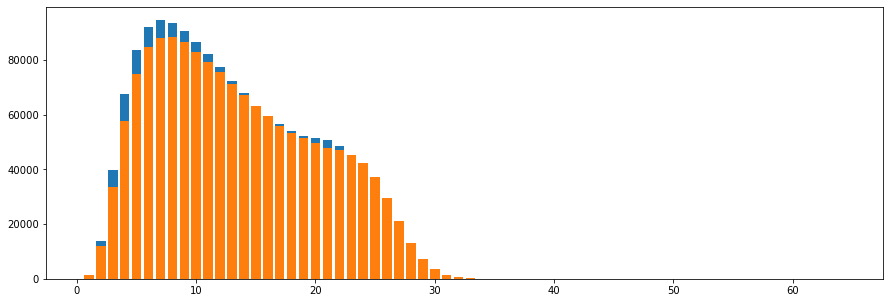

In [10]:
sss["len"]=sss["processed"].apply(lambda x:len(x.split()))
sss[["len","processed"]].sort_values(by="len").to_csv("PT.csv")
sss["len2"]=sss["tweetText"].apply(lambda x:len(x.split()))
pp=pd.DataFrame(sss["len"].value_counts())
pp2=pd.DataFrame(sss["len2"].value_counts())
plt.bar(pp.index,pp["len"].values)
plt.bar(pp2.index,pp2["len2"].values)

In [11]:
result=pd.DataFrame(columns=["model","ngram","Precision","Recall", "Accuracy","MCC","AUC"])
counter=0

In [12]:
params = [(1,1),(1,2),(1,3)]

In [13]:
# model = Pipeline([
#         ('bow', CountVectorizer(max_features=None,preprocessor=None,ngram_range=(1,3),lowercase=False)),  # strings to token integer counts
#         ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
#         ('classifier', SVC(cache_size=1000)),  # train on TF-IDF vectors w/ Naive Bayes classifier
#     ])
# model.fit(trainX.values, trainY[original3].values.flatten())
# pred=model.predict(testX.values)
# print(confusion_matrix(testY[original3].values,pred))
# print(classification_report(testY[original3].values,pred))

In [20]:
for param in params:
    print("MNB_NGRAM: "+str(param))
    model = Pipeline([('bow', CountVectorizer(max_features=None,preprocessor=None,ngram_range=param,lowercase=False)), 
                      ('tfidf', TfidfTransformer()), ('classifier', MultinomialNB()),])
    model.fit(trainX.values, trainY[original3].values.flatten())
    pred=model.predict(testX.values)
#     print(confusion_matrix(testY[original3].values,pred))
#     print(classification_report(testY[original3].values,pred))
#     print("MCC",matthews_corrcoef(testY[original3].values,pred))
#     print("AUC",metrics.roc_auc_score(testY[original3].values,pred))
#     precision_recall_fscore_support(testY[original3].values,pred, average='micro')
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[counter]=["MNB",str(param),matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]
    counter+=1

MNB_NGRAM: (1, 1)
MNB_NGRAM: (1, 2)
MNB_NGRAM: (1, 3)


In [15]:
for param in params:
    print("LR_NGRAM: "+str(param))
    model = Pipeline([('bow', CountVectorizer(max_features=None,preprocessor=None,ngram_range=param,lowercase=False)),
                      ('tfidf', TfidfTransformer()),('classifier',LogisticRegression()), ])    
    model.fit(trainX.values, trainY[original3].values.flatten())
    pred=model.predict(testX.values)
#     print(confusion_matrix(testY[original3].values,pred))
#     print(classification_report(testY[original3].values,pred))
#     print("MCC",matthews_corrcoef(testY[original3].values,pred))
#     print("AUC",metrics.roc_auc_score(testY[original3].values,pred))
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[counter]=["LR",str(param),matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]
    counter+=1

LR_NGRAM: (1, 1)


C:\Users\mech\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR_NGRAM: (1, 2)


C:\Users\mech\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR_NGRAM: (1, 3)


C:\Users\mech\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
result

,model,ngram,Precision,Recall,Accuracy,MCC,AUC
0,LR,"(1, 1)",0.599174,0.799483,0.799483,0.799483,0.799554
1,LR,"(1, 2)",0.648121,0.824032,0.824032,0.824032,0.824064
2,LR,"(1, 3)",0.645485,0.822753,0.822753,0.822753,0.822735
3,MNB,"(1, 1)",0.547861,0.773854,0.773854,0.773854,0.773734
4,MNB,"(1, 2)",0.610244,0.804456,0.804456,0.804456,0.804202
5,MNB,"(1, 3)",0.615600,0.806900,0.806900,0.806900,0.806611


### Text Preprocessing

### Testing Various Input Configurations 

### CAT

#### CAT2

In [ ]:
vec_layer = TextVectorization(ngrams=param,max_tokens=None,output_sequence_length=50)
vec_layer.adapt(trainX.tolist())
tf.keras.backend.clear_session()
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=1)]
def DNN(sequence_length = 60, embedding_dim=16,optimizer='adam'):
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(Dense(16, activation="relu"))
    M.add(Dense(16, activation="relu"))
    M.add(Flatten())
    M.add(Dense(50, activation="relu"))
    M.add(Dense(2,activation='softmax')) 
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"]) 
    return M
# model =DNN( sequence_length = 70, embedding_dim=16,optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
# H=model.fit(trainX, trainY[cat2],epochs=1, batch_size=100, validation_split=0.1, callbacks=callbacks)
# model.summary()
# plotCompare(H.history['loss'],H.history['val_loss'],["train","test"])

In [ ]:
# pred=model.predict(testX)
# print(confusion_matrix(testY[original3],pd.DataFrame( pred,columns=[0,1]).idxmax(axis=1)))
# print(classification_report(testY[original3],pd.DataFrame( pred,columns=[0,1]).idxmax(axis=1)))

In [ ]:
tf.get_logger().setLevel('ERROR')
for param in params:
    tf.keras.backend.clear_session()
    vec_layer = TextVectorization(ngrams=param,max_tokens=None,output_sequence_length=50)
    vec_layer.adapt(trainX.tolist())
    model =DNN( sequence_length = 50, embedding_dim=16,optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
    model.fit(trainX, trainY[cat2],epochs=1, batch_size=500, validation_split=0.1, callbacks=callbacks)
    pred=pd.DataFrame( model.predict(testX),columns=[0,1]).idxmax(axis=1) 
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[counter]=["DNN",str(param),matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]
    print( result.loc[counter])
    counter+=1

2207/2207 [==============================] - 58s 26ms/step - loss: 0.4691 - accuracy: 0.7743 - val_loss: 0.4304 - val_accuracy: 0.8009
model             DNN
ngram          (1, 1)
Precision    0.605337
Recall       0.802515
Accuracy     0.802515
MCC          0.802515
AUC          0.802375
Name: 6, dtype: object
2207/2207 [==============================] - 695s 315ms/step - loss: 0.4492 - accuracy: 0.7861 - val_loss: 0.3948 - val_accuracy: 0.8222
model             DNN
ngram          (1, 2)
Precision    0.645435
Recall       0.822126
Accuracy     0.822126
MCC          0.822126
AUC          0.821894
Name: 7, dtype: object
1508/2207 [===================>..........] - ETA: 9:57 - loss: 0.4867 - accuracy: 0.7545

In [23]:
result

,model,ngram,Precision,Recall,Accuracy,MCC,AUC
0,LR,"(1, 1)",0.599174,0.799483,0.799483,0.799483,0.799554
1,LR,"(1, 2)",0.648121,0.824032,0.824032,0.824032,0.824064
2,LR,"(1, 3)",0.645485,0.822753,0.822753,0.822753,0.822735
3,MNB,"(1, 1)",0.547861,0.773854,0.773854,0.773854,0.773734
4,MNB,"(1, 2)",0.610244,0.804456,0.804456,0.804456,0.804202
5,MNB,"(1, 3)",0.615600,0.806900,0.806900,0.806900,0.806611


In [394]:
# tf.keras.backend.clear_session()
# def LSTM_model(hp=None):
#     hp_ngrams = hp.Choice('ngrams', values=[1,2,3])
#     vec_layer = TextVectorization(ngrams=hp_ngrams,max_tokens=None,output_sequence_length=50)
#     vec_layer.adapt(trainX.tolist())
#     M = Sequential()
#     M.add(vec_layer),
#     M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=16,mask_zero=True))
#     M.add(LSTM(50, kernel_regularizer=tf.keras.regularizers.L2(l2=0.5), return_sequences =True))
#     M.add(Activation(tf.keras.activations.relu))
#     M.add(LSTM(50, kernel_regularizer=tf.keras.regularizers.L2(l2=0.2), return_sequences =False))
#     M.add(Activation(tf.keras.activations.relu))
#     M.add(Dense(50, kernel_regularizer=tf.keras.regularizers.L2(l2=0.2), activation=LeakyReLU()))
#     M.add(Dense(2,activation='softmax')) 
#     M.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="categorical_crossentropy",metrics=["accuracy"]) 
#     return M 
# tuner = kt.RandomSearch (LSTM_model, objective='val_loss', executions_per_trial=1, overwrite=True, max_trials=100,directory='my_dir',project_name='DNN')
# tuner.search(trainX, trainY[cat2], epochs=1, validation_data=(testX, testY[cat2]),batch_size=75, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=1)])
# tuner.results_summary()

In [395]:
tf.keras.backend.clear_session()
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=1)]
def LSTM_model(sequence_length = 140, embedding_dim=16,ngram=1,optimizer='adam',hidden=16):
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(16, LeakyReLU(),kernel_regularizer=tf.keras.regularizers.L2(l2=0.5), return_sequences =True))
    M.add(LSTM(1,LeakyReLU(), kernel_regularizer=tf.keras.regularizers.L2(l2=0.2), return_sequences =True))
    M.add(Flatten())
    M.add(Dense(10,activation='elu'))
    M.add(Dense(2,activation='softmax')) 
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"]) 
    return M
# model =LSTM_model(sequence_length = 50, embedding_dim=16,ngram=2,optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),hidden=50)
# H=model.fit(trainX, trainY[cat2],epochs=100, batch_size=500, validation_split=0.1, callbacks=callbacks)
# plotCompare(H.history['loss'],H.history['val_loss'],["train","test"])
# model.summary()

In [ ]:
tf.get_logger().setLevel('ERROR')
for param in params:
    tf.keras.backend.clear_session()
    vec_layer = TextVectorization(ngrams=param,max_tokens=None,output_sequence_length=50)
    vec_layer.adapt(trainX.tolist())
    model =LSTM_model( sequence_length = 50, embedding_dim=16,optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002))
    model.fit(trainX, trainY[cat2],epochs=3, batch_size=100, validation_split=0.1, callbacks=callbacks)
    pred=pd.DataFrame( model.predict(testX),columns=[0,1]).idxmax(axis=1) 
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[counter]=["LSTM",str(param),matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]
    counter+=1

Epoch 1/3
11033/11033 [==============================] - 2757s 249ms/step - loss: 2.6580 - accuracy: 0.7517 - val_loss: 0.4633 - val_accuracy: 0.7950
Epoch 2/3
11033/11033 [==============================] - 2742s 249ms/step - loss: 0.4481 - accuracy: 0.8027 - val_loss: 0.4524 - val_accuracy: 0.7966
Epoch 3/3
11033/11033 [==============================] - 2751s 249ms/step - loss: 0.4332 - accuracy: 0.8093 - val_loss: 0.4463 - val_accuracy: 0.7982
Epoch 1/3
11033/11033 [==============================] - 4792s 434ms/step - loss: 2.6438 - accuracy: 0.7540 - val_loss: 0.4390 - val_accuracy: 0.8074
Epoch 2/3
11033/11033 [==============================] - 4819s 437ms/step - loss: 0.3545 - accuracy: 0.8611 - val_loss: 0.4587 - val_accuracy: 0.8036
Epoch 1/3
11033/11033 [==============================] - 8764s 793ms/step - loss: 2.7871 - accuracy: 0.7493 - val_loss: 0.4446 - val_accuracy: 0.8027
Epoch 2/3
11033/11033 [==============================] - 9054s 821ms/step - loss: 0.2536 - accuracy:

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model,**kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.supports_masking = True
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],d_model=d_model)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
class ScalerMult(Layer):
    def __init__(self, d_model,**kwargs):
        super(ScalerMult, self).__init__(**kwargs)
        self.mult = tf.math.sqrt(tf.cast(d_model, tf.float32))
        self.supports_masking = True
    def call(self, inputs):
        return inputs * self.mult   
    
def Encoder(dim,encoders,hidden,P,key_dim,l2,axis=-1,epsilon=1e-6,activation="relu"):
    temp=[None]*encoders
    for e in range(encoders):
        AT= MultiHeadAttentionMaskProp(dim, key_dim)(P)
        AD1 = Add()([AT, P])
        NORM1 = LayerNormalization(epsilon=epsilon, axis=axis)(AD1)
        FF = Dense(hidden, activation, kernel_regularizer=tf.keras.regularizers.L2(l2=l2))(NORM1)
        FF = Dropout(0.4)(FF)
        FF = Dense(dim, activation)(FF)
        AD2 = Add()([FF, NORM1])
        temp[e]=LayerNormalization(epsilon=epsilon, axis=axis)(AD2)
    if encoders==1: return temp[0]
    return concatenate(temp) 

class MultiHeadAttentionMaskProp(layers.Layer):
    def __init__(self ,dim, key_dim, **kwargs):
        super(MultiHeadAttentionMaskProp,self).__init__(**kwargs)
        self.MultiHeadAttention = MultiHeadAttention(num_heads=dim, key_dim=key_dim)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        t=mask[:, tf.newaxis, tf.newaxis, :]
        output = self.MultiHeadAttention(inputs,inputs,inputs,t)  
        return output  

In [ ]:
tf.keras.backend.clear_session()
def Transformer_Encoder_Model(vocab=len(vec_layer.get_vocabulary()),optimizer=tf.keras.optimizers.Adam(lr=0.001),embedding_dim=16, hidden=16,encoders=5,key_dim=16,l2=0.5):
    x =Input(shape=(1,), dtype=tf.string)
    V =vec_layer(x)    
    E=Embedding(input_dim=vocab,output_dim=embedding_dim,mask_zero=True)(V)#try with or without masking
    E=ScalerMult(embedding_dim)(E)
    P=PositionalEncoding(vocab,embedding_dim)(E)
    p=Masking()(P)#with and without
    out=Encoder(embedding_dim,encoders,hidden,P,key_dim,l2,axis=-1)
    out=Flatten()(out)
    out=Dense(2,'linear')(out)
    out=Dense(2,'softmax')(out)
    M=tf.keras.models.Model(inputs=x,outputs=out) 
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])  
    return M
model=Transformer_Encoder_Model()
# tf.keras.utils.plot_model(Transformer_Encoder_Model())
# H=model.fit(trainX.values, trainY[cat2].values,epochs=1,batch_size=100,validation_split=0.1, callbacks=callbacks)
# model.summary()

In [ ]:
tf.get_logger().setLevel('ERROR')
for param in params:
    tf.keras.backend.clear_session()
    vec_layer = TextVectorization(ngrams=param,max_tokens=None,output_sequence_length=50)
    vec_layer.adapt(trainX.tolist())
    model =Transformer_Encoder_Model( vocab=len(vec_layer.get_vocabulary()),embedding_dim=16,optimizer=tf.keras.optimizers.Adam(lr=0.001))
    model.fit(trainX, trainY[cat2],epochs=1, batch_size=100, validation_split=0.1, callbacks=callbacks)
    pred=pd.DataFrame( model.predict(testX),columns=[0,1]).idxmax(axis=1) 
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[counter]=["TFENC",str(param),matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]
    counter+=1

In [ ]:
#     tf.keras.backend.clear_session()
#     vec_layer = TextVectorization(ngrams=param,max_tokens=None,output_sequence_length=50)
#     vec_layer.adapt(trainX.tolist())
#     model =Transformer_Encoder_Model( vocab=len(vec_layer.get_vocabulary()),embedding_dim=16,optimizer=tf.keras.optimizers.Adam(lr=0.01))
#     model.fit(trainX, trainY[cat2],epochs=1, batch_size=100, validation_split=0.1, callbacks=callbacks)
#     pred=pd.DataFrame( model.predict(testX),columns=[0,1]).idxmax(axis=1) 
#     per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
#     result.loc[counter]=["TFENC",str(param),matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]
#     counter+=1
result

In [ ]:
vec_layer = TextVectorization(ngrams=2,max_tokens=None,output_sequence_length=50)
vec_layer.adapt(trainX.tolist())

In [ ]:
len(vec_layer.get_vocabulary())

In [ ]:
plotCompare(H.history['loss'],H.history['val_loss'],["train","test"])
sea

Creating a preprocessor object

## Training & evaluating a model

In [ ]:
# sentiment140Value=(getQueryFromMongoDB("processedSentiment140"))[["_id",'SentimentScore','processed']]
# sentiment140Value=sentiment140Value.sample(frac=1)
# sentiment140Value=sentiment140Value.drop_duplicates(subset=['processed'])
# trainX, testX, trainY, testY =train_test_split(sentiment140Value['processed'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

In [ ]:
# trainX, testX, trainY, testY =train_test_split(sentiment140Value['tweetText'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

In [ ]:
# model= getSentimentModel(ngram=(1,3))
# model.fit(trainX, trainY) 
# pred=model.predict(testX)
# print(confusion_matrix(testY,pred))
# print(classification_report(testY,pred))

In [ ]:
# def BiLSTM_model(dataset,vocab_size = 5000, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
#     vec_layer = TextVectorization(
#         standardize=None, 
#         output_mode=mode,    #"int", "binary", "count" or "tf-idf"
#         ngrams=ngram,
# #         max_tokens=vocab_size,
#         pad_to_max_tokens=True,
#         output_sequence_length=sequence_length
#                         )
#     vec_layer.adapt(dataset)
#     M = Sequential()
#     M.add(vec_layer),
#     M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
#     M.add(Bidirectional(LSTM(embedding_dim)))
#     M.add(Dense(hidden, activation='relu'))
#     M.add(Dense(2, activation='softmax'))    
#     M.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=["CategoricalAccuracy"])  
#     return M

## Experiment Results

# Stock Forecasting

## Load Data

Define Which Stock to Use and Prediction Length

In [4]:
stock="MSFT"
# MSFT=loadStockData(stock)
data=load(stock) #Load From Disk. Requires loadStockData to be run at least once for it to store an archived version
period=5 #lookback Period
lookAhead=5 #How many days ahead to predict 
data.drop(columns=["Dividends","Stock Splits"],inplace=True)

Inspect Data for nulls

In [5]:
data=data.sort_values('Date')
print("NULLs\n")
print(data.isnull().sum())
datarange=[data.index.min().date(), data.index.max().date()]
print("Data Range: ",datarange)

NULLs

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Data Range:  [datetime.date(1986, 3, 13), datetime.date(2021, 4, 5)]


Expand Data To Contain All Days Including The Missing Days 

In [6]:
data=data.resample('D').first()
data["wasNa"]=data['Close'].isna()#mark filled in spots for future reference
print(data["wasNa"].value_counts())

False    8837
True     3971
Name: wasNa, dtype: int64


Fill Gaps

In [7]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
# limit_direction{{‘forward’, ‘backward’, ‘both’}}
data=data.interpolate(method='polynomial', order=2, limit_direction='both')
# data.fillna(0)

Transform

In [8]:
TTI=30
data=data[['Close']]
# data["EWMAS"]=data[['Close']]-data[['Close']].ewm(span=TTI).mean()
# data["EWMAHL"]=data[['Close']]-data[['Close']].ewm(halflife=TTI).mean()
# data["R"]=data[['Close']]-data[['Close']].rolling(TTI).mean()
logged=np.log(data[["Close"]])
# data["L_EWMAS"]=logged[['Close']]-logged[['Close']].ewm(span=TTI).mean()
# data["L_EWMAHL"]=logged[['Close']]-logged[['Close']].ewm(halflife=TTI).mean()
data["L_R"]=logged[['Close']]-logged[['Close']].rolling(TTI).mean()

In [10]:
for column in data.columns[1:]:
    data["D_"+column]=data[column].diff()

(0.000638918276971569,
 [0.0006867762548595783, -6.926487759226666e-07, -4.71653291120866e-05])

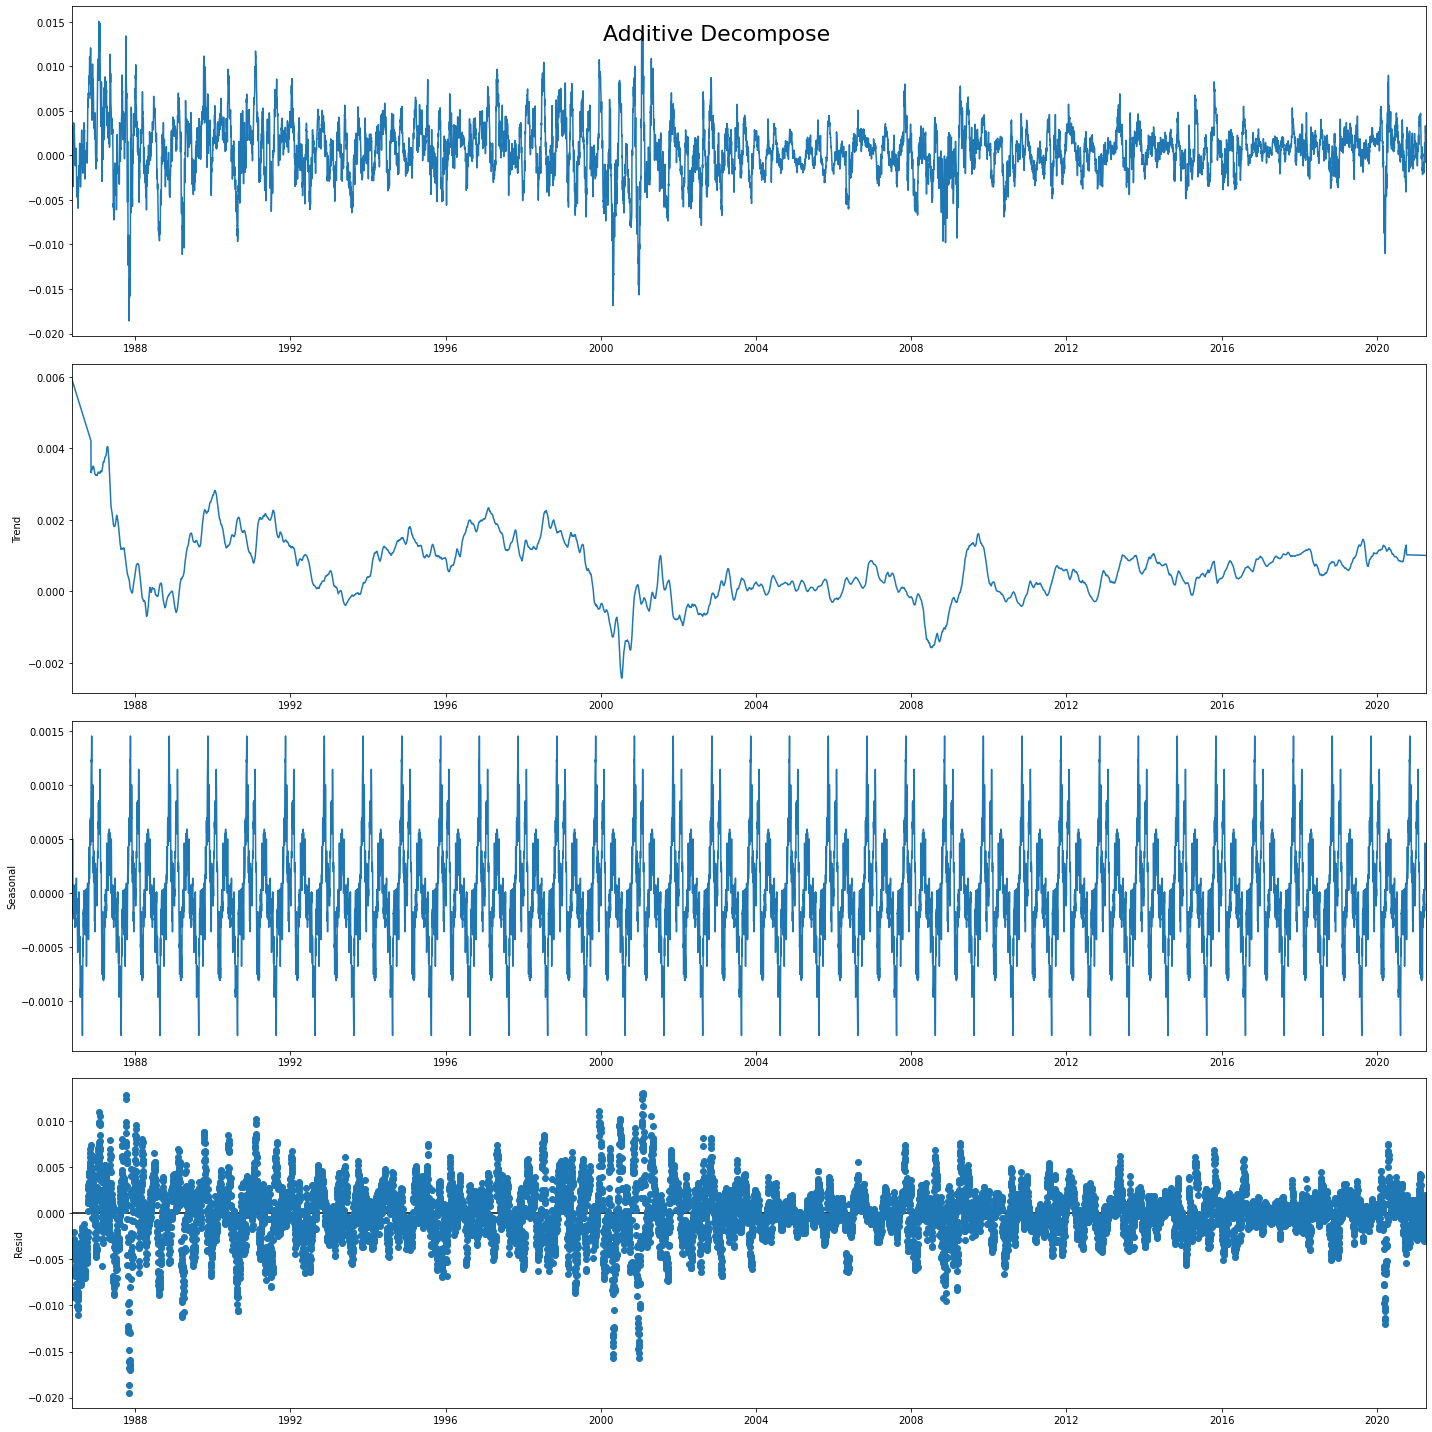

In [359]:
logged=np.log(data[["Close"]].rolling(TTI).mean()).diff()
result_add = seasonal_decompose(logged.dropna(), model='a', extrapolate_trend='freq', period=365)
result_add.plot().suptitle('Additive Decompose', fontsize=22) 
r=[result_add.trend.mean(),result_add.seasonal.mean(),result_add.resid.mean()]
sum(r),r

In [353]:
data["D_L_R"]

Date
1986-04-12    0.009315
1986-04-13    0.001219
1986-04-14   -0.002516
1986-04-15    0.000936
1986-04-16    0.033349
                ...   
2021-04-01    0.026339
2021-04-02    0.017470
2021-04-03    0.007879
2021-04-04   -0.000289
2021-04-05   -0.008834
Freq: D, Name: D_L_R, Length: 12778, dtype: float64

In [339]:
# (np.exp((data["D_L_R"]+data["L_R"].shift(1))+np.log(data["Close"]).rolling(TTI).mean())).dropna()

In [337]:
# TTI=20
# data=data[['Close']]
# data[str(TTI)+"_D_Mean"]= data[['Close']].rolling(TTI).mean()
# data[str(TTI)+"_D_EWM_span"]= data[['Close']].ewm(span=TTI).mean()
# data[str(TTI)+"_D_EWM_halflife"]= data[['Close']].ewm(halflife=TTI).mean()
# window=data.rolling(TTI)   
# for column in data.columns[:4]:
#     data[column+"_MNorm"]=(data[column]- data[column].mean())/data[column].std()
# for column in data.columns[:4]:
#     data[column+"_RMNorm"]=(data[column]-window[column].mean())/window[column].std()
# data["log_diff"] = np.log(data["Close"]).diff()
# for column in data.columns[:4]: data[column+"_diff"]=data[column].diff() 

In [338]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# r=[]
# for column in data.columns[-3:]: 
#     result_add = seasonal_decompose(data[column].dropna(), model='a', extrapolate_trend='freq', period=365)
#     plt.rcParams.update({'figure.figsize': (20,20)})
#     result_add.plot().suptitle('Additive Decompose', fontsize=22) 
#     r.append([result_add.trend.mean(),result_add.seasonal.mean(),result_add.resid.mean()])
#     plt.show()
# for p in r:
#     print(sum([e**2 for e in p]))
# r

In [18]:
scalers = [MinMaxScaler() for column in data.columns]
dataNormed=data.copy(deep=True)
columnscalers=dict(zip(dataNormed.columns,scalers))
for column,scale in columnscalers.items():
    dataNormed[column]=scale.fit_transform(data[[column]])
data,dataNormed=data.dropna(),dataNormed.dropna()

In [19]:
# data.plot(subplots=True,figsize=(30,100)) 

In [20]:
# dataNormed.plot(subplots=True,figsize=(30,100))

In [21]:
def createTimeSeriesData(data,inputColumns,shifts=5,outputColumns=None,outputlengthTimeSteps=1):
    temp=data[inputColumns]
    for i in range(1,shifts): 
        temp=pd.merge(left=data[inputColumns].shift(i),
                      left_index=True, right=temp,right_index=True)
    temp=temp.dropna()
    if outputColumns is not None: 
        return temp[:-outputlengthTimeSteps],createTimeSeriesData(data,outputColumns,shifts=outputlengthTimeSteps)[shifts:]
    return temp

In [22]:
dataNormed

,Close,L_R,D_L_R
Date,,,
1986-04-12,0.000028,0.666116,0.483837
1986-04-13,0.000028,0.667729,0.459400
1986-04-14,0.000027,0.664400,0.448128
1986-04-15,0.000027,0.665638,0.458545
1986-04-16,0.000036,0.709753,0.556374
...,...,...,...
2021-04-01,0.966817,0.654486,0.535217
2021-04-02,0.986593,0.677596,0.508449
2021-04-03,0.997654,0.688019,0.479503


## s

In [23]:
print("  ".join(data.columns))
inputcolumn=data.columns[-1]
inputcolumn

Close  L_R  D_L_R


'D_L_R'

In [24]:
inputcolumn

'D_L_R'

In [47]:
# Shuffle but within period (1D vs 2D)
# Try training Model From all Available stocks
dataIn,dataOut=createTimeSeriesData(dataNormed,inputcolumn,outputColumns=["D_L_R"],outputlengthTimeSteps=lookAhead,shifts=period)
dataIn=(dataIn.to_numpy().reshape(dataIn.shape[0],period,-1))
dataOut=(dataOut.to_numpy().reshape(dataOut.shape[0],lookAhead,-1))
# data[inputcolumn]

In [48]:
split=0.2
trainx,vtx,trainy,vty=train_test_split(dataIn,dataOut,test_size=split,shuffle=False)
vx,tx,vy,ty=train_test_split(vtx,vty,test_size=0.5,shuffle=False)
print("Total Samples:",len(dataIn),"\t\t\tTraining Samples:",len(trainx))
print("Total Validation Samples:",len(vy),"\t\tTest Samples:",len(ty))
print("Input Data Shape:",tx.shape[1:],"\t\tOutput Data Shape:",ty.shape[1:])

Total Samples: 12769 			Training Samples: 10215
Total Validation Samples: 1277 		Test Samples: 1277
Input Data Shape: (5, 1) 		Output Data Shape: (5, 1)


In [49]:
# ax = data['Close'].plot()
# f,f[len(trainx):],f[len(trainx)+len(vx):]=np.full((len(dataIn)), 1),2,3
# ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),f[np.newaxis],cmap='viridis', alpha=0.5)
# plt.show()

Split by time period

In [50]:
def plotMultVariate(Din,Dout,DinSteps):
    for i in range(len(Din)):
        plt.plot(range(i,i+DinSteps),Din[i],'g')
        plt.plot(range(i,i+DinSteps),Dout[i],alpha=0.5)
    plt.show()
def plotVisual(vs,ps,period=period,t=0.5):
    for i in range(len(vs)):
        plotMultVariate(vs[:i],ps,period)
        plt.show()
        time.sleep(0.5)
        clear_output(wait=True) 

train validate test
train+validation Test
train+validate+test

moving average removes trend and seasonality
can be worse than regular time series

series + moving avg of differenced
trailing moving average of differenced + centered moving average of past series

Take original data and shift by 1 timestep and call that baseline

normalization

shuffle to avoid sequence bias

error MSE RMSE MAE MAPE

Transform the time series data so that it is stationary. Specifically, a lag=1 differencing to remove the increasing trend in the data.

Transform the time series into a supervised learning problem. Specifically, the organization of data into input and output patterns where the observation at the previous time step is used as an input to forecast the observation at the current time step

Transform the observations to have a specific scale. Specifically, to rescale the data to values between -1 and 1 to meet the default hyperbolic tangent activation function of the LSTM model.

## Data Exploration

## Creating Performance Baselines 

In [298]:
columns=[s+"_t"+str(i) for i in range(lookAhead) for s in ["Train","Val","Test"]]
columns.insert(0, "model")
benchmarker=pd.DataFrame(columns=columns)

In [240]:
def evaluatePredictions(true,pred):
    shape= true.shape[1:]
    results=[None]*shape[0]
    for i in range(shape[0]):
        m = tf.keras.metrics.MeanSquaredError()
        m.update_state(true[:,i],pred[:,i])
        results[i]=m.result().numpy()
        m.reset_states
    return results

repeat last input baseline

In [260]:
repeatLastTrain=np.array([np.full((5,1), v[-1]) for v in trainx])
repeatLastVal=np.array([np.full((5,1), v[-1]) for v in vx])
repeatLastTest=np.array([np.full((5,1), v[-1]) for v in tx])

In [305]:
print(evaluatePredictions(trainy,repeatLastTrain))
print(evaluatePredictions(vy,repeatLastVal))
print(evaluatePredictions(ty,repeatLastTest))

[0.0045545883, 0.0068955687, 0.0065074433, 0.006200882, 0.006241024]
[0.0019358958, 0.002970956, 0.002572051, 0.0024250417, 0.0026195953]
[0.0041874046, 0.005780954, 0.004464219, 0.004063796, 0.00463643]


In [326]:
benchmarker.loc[0]=0
benchmarker.loc[0]["model"]="RepeatBL"
benchmarker.iloc[0][1:]=np.array([evaluatePredictions(trainy,repeatLastTrain),evaluatePredictions(vy,repeatLastVal),evaluatePredictions(ty,repeatLastTest)]).reshape(-1,order='F')

Shift by one baseline

In [327]:
shiftTrain=trainx[1:]
shiftVal=vx[1:]
repeatTest=tx[1:]

In [328]:
print(evaluatePredictions(trainy[:-1],shiftTrain))
print(evaluatePredictions(vy[:-1],shiftVal))
print(evaluatePredictions(ty[:-1],repeatTest))

[0.0062011415, 0.0062020314, 0.0062014796, 0.0062013646, 0.006201017]
[0.0024284406, 0.0024255423, 0.0024260064, 0.002425009, 0.0024211856]
[0.0040517957, 0.004057182, 0.004063468, 0.0040648635, 0.004066905]


In [329]:
benchmarker.loc[1]=0
benchmarker.loc[1]["model"]="ShiftBL"
benchmarker.iloc[1][1:]=np.array([evaluatePredictions(trainy[:-1],shiftTrain),evaluatePredictions(vy[:-1],shiftVal),evaluatePredictions(ty[:-1],repeatTest)]).reshape(-1,order='F')
benchmarker

,model,Train_t0,Val_t0,Test_t0,Train_t1,Val_t1,Test_t1,Train_t2,Val_t2,Test_t2,Train_t3,Val_t3,Test_t3,Train_t4,Val_t4,Test_t4
0,RepeatBL,0.004555,0.001936,0.004187,0.006896,0.002971,0.005781,0.006507,0.002572,0.004464,0.006201,0.002425,0.004064,0.006241,0.00262,0.004636
1,ShiftBL,0.006201,0.002428,0.004052,0.006202,0.002426,0.004057,0.006201,0.002426,0.004063,0.006201,0.002425,0.004065,0.006201,0.002421,0.004067


## Testing Different Models Performance

In [330]:
tf.keras.backend.clear_session()
Epochs = 100
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=5)]
lr_shedule=tf.keras.callbacks.LearningRateScheduler( lambda x: 1e-8*10**(x/20))

In [331]:
def compileFit(model, TrainingX=trainx, TrainingY=trainy,ValX=vx,ValY=vy,optimizer="adam",loss="mean_squared_error", patience=3,epochs=Epochs,shuffle=True,batch_size=75):
    model.compile(loss=loss,optimizer=optimizer)
    history = model.fit(TrainingX, TrainingY,shuffle=shuffle, batch_size=batch_size,validation_data=(vx,vy),epochs=epochs,callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=patience))  
    return history

In [333]:
trainx.shape,trainy.shape

((10215, 5, 1), (10215, 5, 1))

### Simple-RNN

#### Finding Params

In [32]:
# tf.keras.backend.clear_session()
# def RNN_model(hp=None):
#     M = Sequential()
# #     hp_units = hp.Int('units', min_value=400, max_value=512, step=32)
#     hp_units=400  
#     M.add(Input(shape=trainx.shape[1:]))
#     M.add(LayerNormalization(axis=1))
#     M.add(SimpleRNN(hp_units, return_sequences=True))
#     M.add(LeakyReLU())
#     M.add(SimpleRNN(hp_units))
#     M.add(LeakyReLU())
#     M.add(Dense(1))
#     hp_learning_rate = hp.Choice('learning_rate', values=[0.01,0.001,0.0001,0.00001,0.000001])
# #     hp_learning_rate=0.000001
#     M.compile(loss="huber",optimizer=SGD(lr=hp_learning_rate, momentum=0.9),metrics=["mae"])
#     return M
# # model=RNN_model()
# # history=model.fit(trainx, trainy,shuffle=True, batch_size=75,validation_data=(vx,vy),epochs=1000,callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=3))  
# tuner = kt.RandomSearch (RNN_model, objective='val_loss',
#                         executions_per_trial=1,
#                          overwrite=True,
#                       max_trials=100,directory='my_dir',
#                      project_name='RNN_model')
# tuner.search(trainx, trainy, epochs=1000, validation_data=(vx,vy),batch_size=75 ,callbacks=callbacks)

In [33]:
# best_hps=tuner.get_best_hyperparameters(num_trials=1)
# best=best_hps[0]
# # best.get('units'), 
# best.get('learning_rate')

#### Deploying the best model

In [34]:
tf.keras.backend.clear_session()
# callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=1)]
# tf.config.optimizer.set_jit(False)
# tf.config.optimizer.set_experimental_options({"constant_folding":False,"loop_optimization":False,"function_optimization":True,"arithmetic_optimization":True})

Epoch 1/100
103/103 [==============================] - 4s 20ms/step - loss: 5.9669 - val_loss: 0.0302
Epoch 2/100
103/103 [==============================] - 2s 17ms/step - loss: 0.0409 - val_loss: 0.0272
Epoch 3/100
103/103 [==============================] - 2s 17ms/step - loss: 0.0396 - val_loss: 0.0249
Epoch 4/100
103/103 [==============================] - 2s 17ms/step - loss: 0.0380 - val_loss: 0.0236
Epoch 5/100
103/103 [==============================] - 2s 17ms/step - loss: 0.0388 - val_loss: 0.0266
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 5, 1)              0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 5, 400)            160800    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 400)               320400    
________

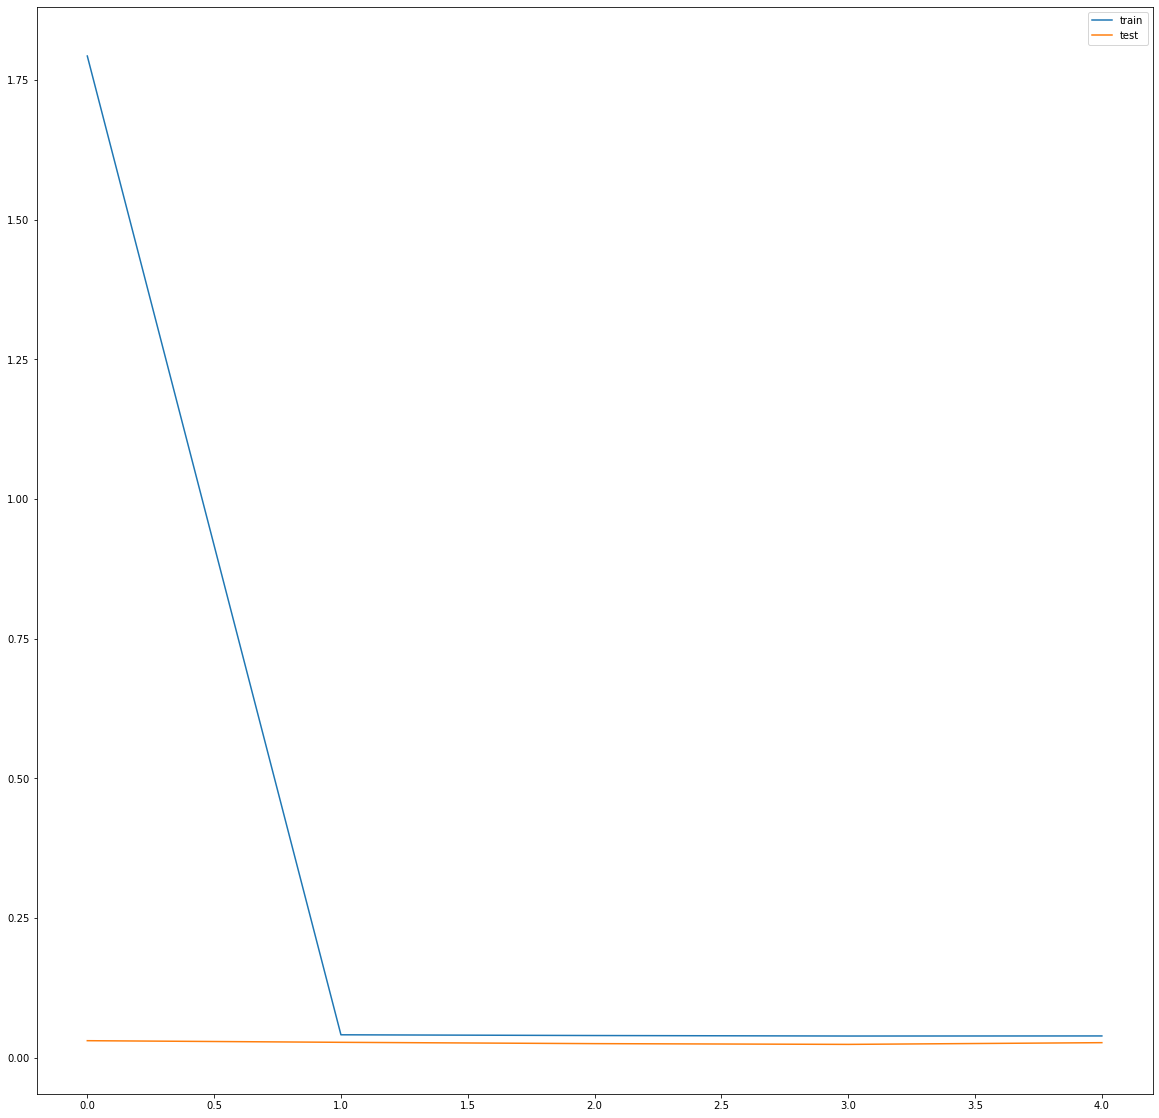

In [334]:
tf.keras.backend.clear_session()
def RNN_model(inputShape,activation='relu',hidden=16, stateful=False):
    M = Sequential()
    if stateful: M.add(Input(batch_input_shape=inputShape))
    else: M.add(Input(shape=inputShape))  
    M.add(Masking())
#     M.add(LayerNormalization(axis=1)) 
    M.add(SimpleRNN(hidden, kernel_regularizer=tf.keras.regularizers.L2(l2=0.5),activation=LeakyReLU(), return_sequences=True))
    M.add(SimpleRNN(hidden,kernel_regularizer=tf.keras.regularizers.L2(l2=0.1),activation=LeakyReLU() ))
    M.add(Dense(lookAhead))
    return M
# losses 'mean_squared_logarithmic_error','mean_squared_error','mean_absolute_error' "huber"
model=RNN_model(inputShape=trainx.shape[1:],activation='relu',hidden=400,stateful=False)
history=compileFit(model,loss='mae',epochs=100,optimizer=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08),shuffle=True,batch_size=100,patience=0)
# model.save("RNN_model")
# model=tf.keras.models.load_model('RNN_model')
model.summary()
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])

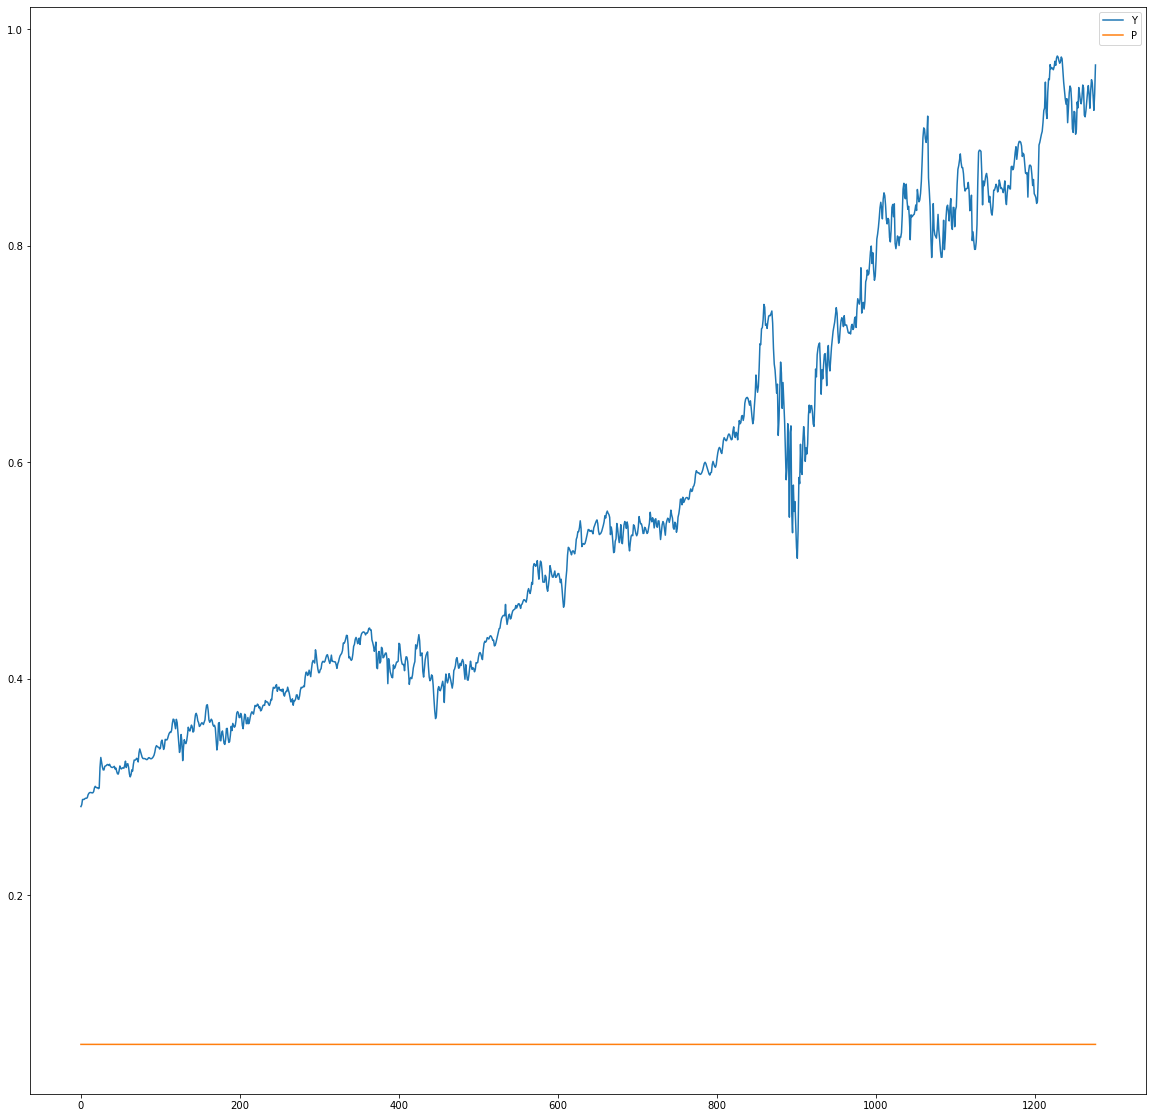

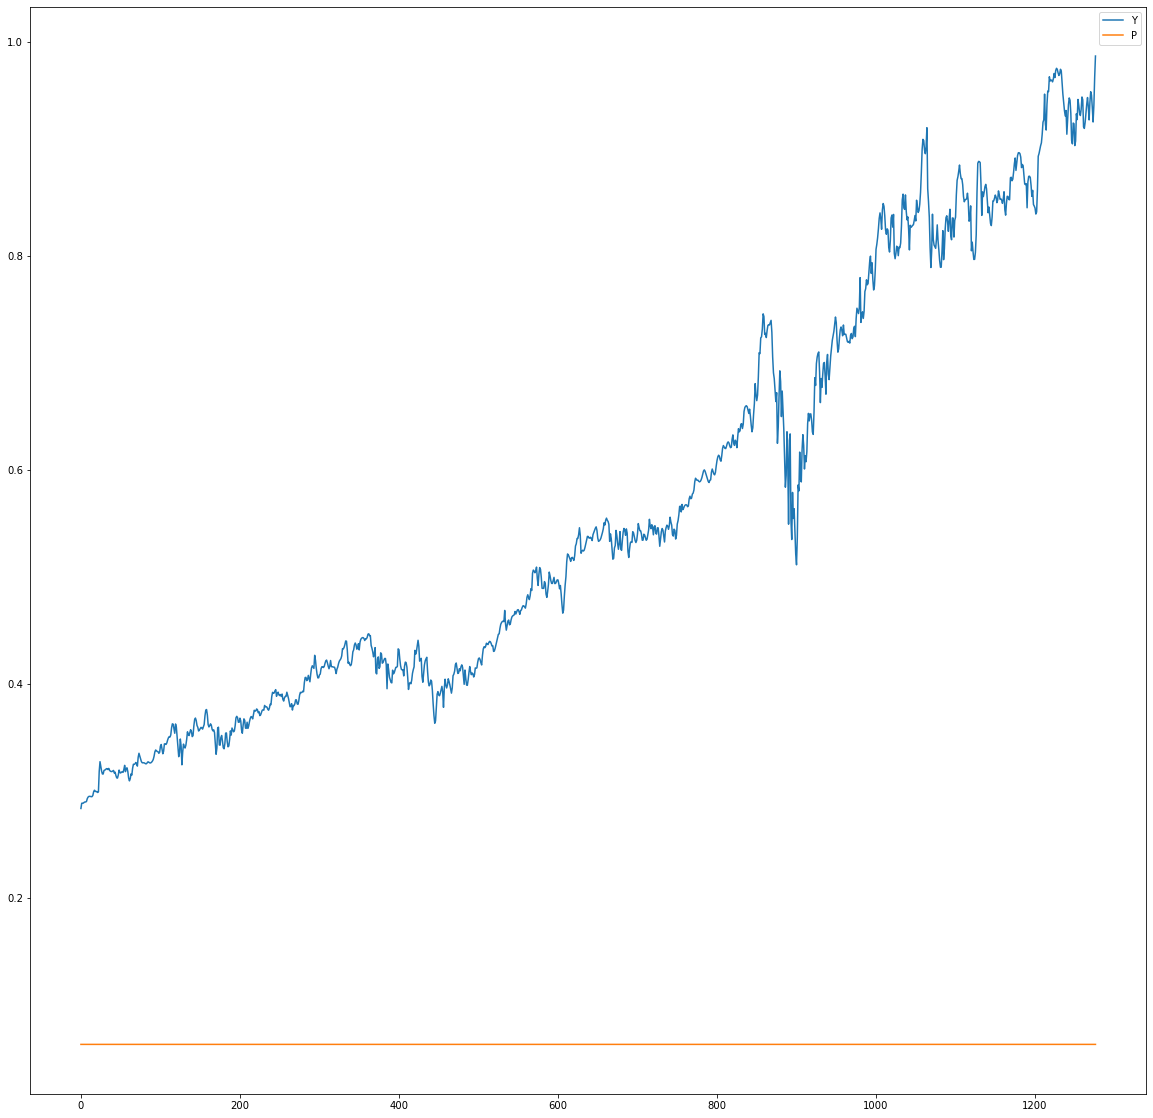

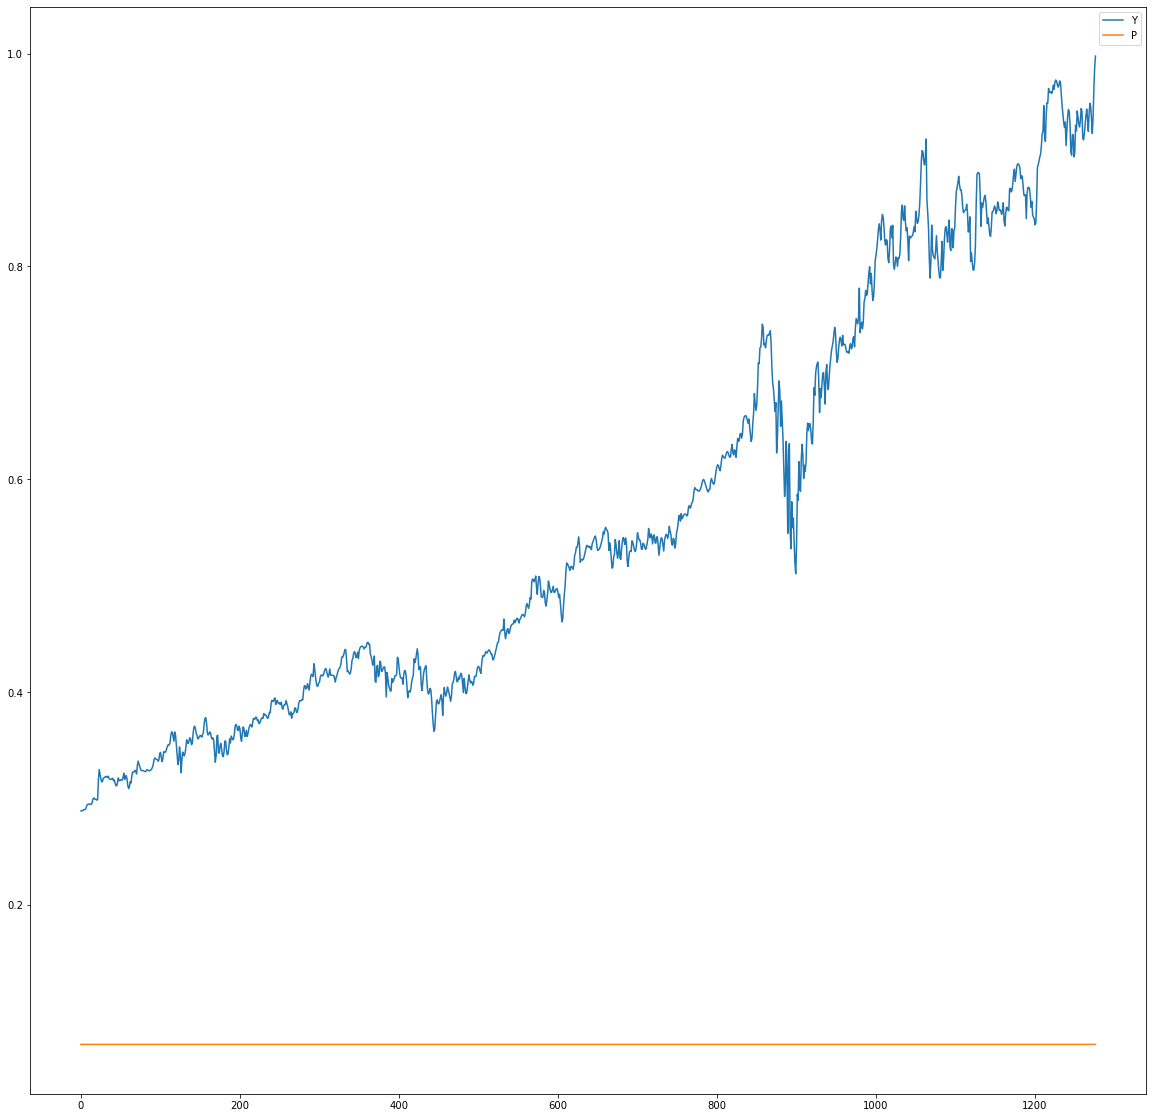

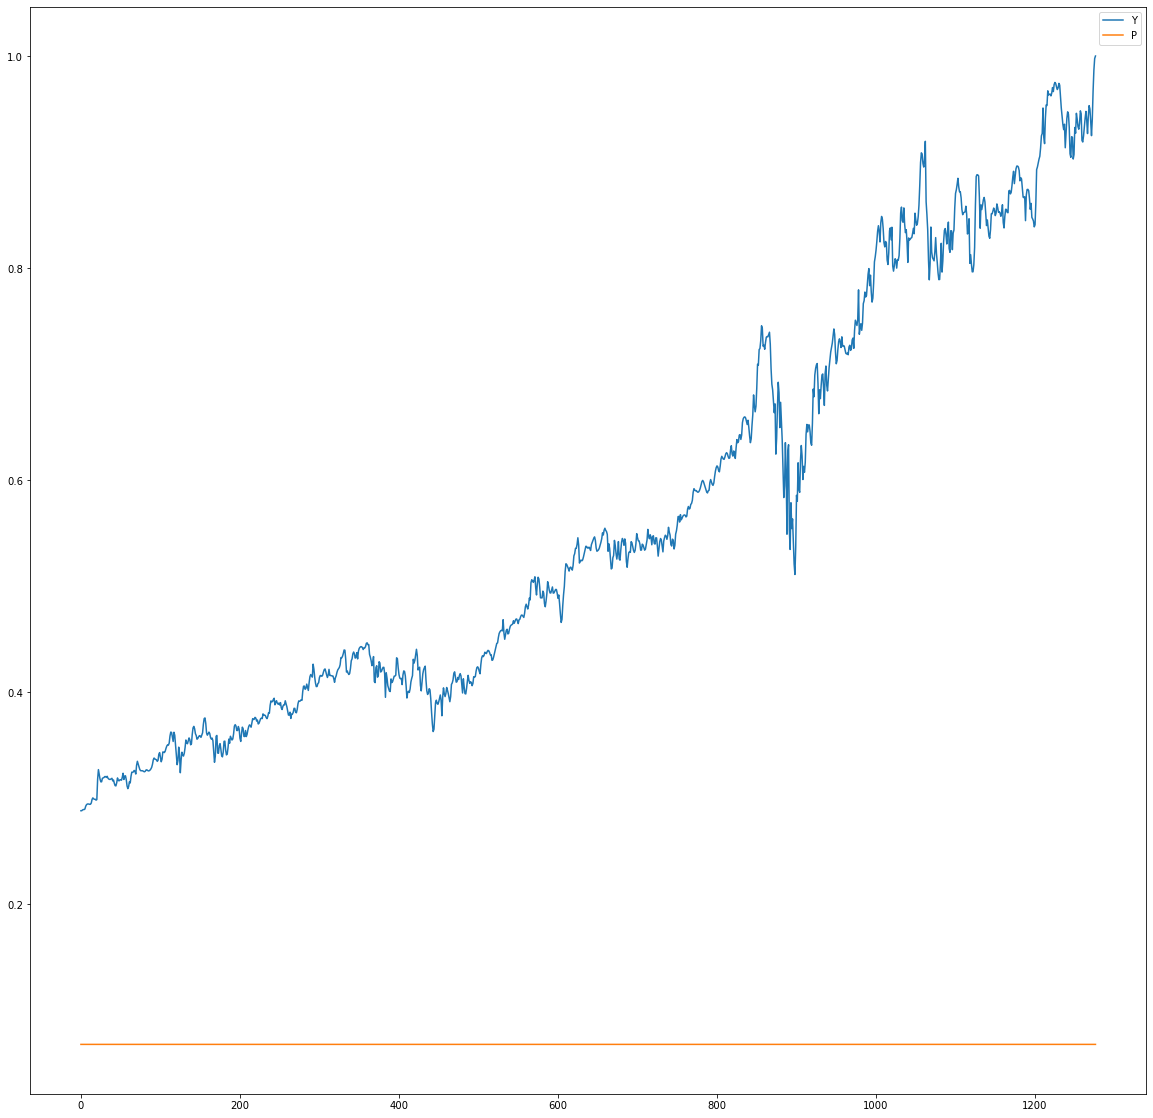

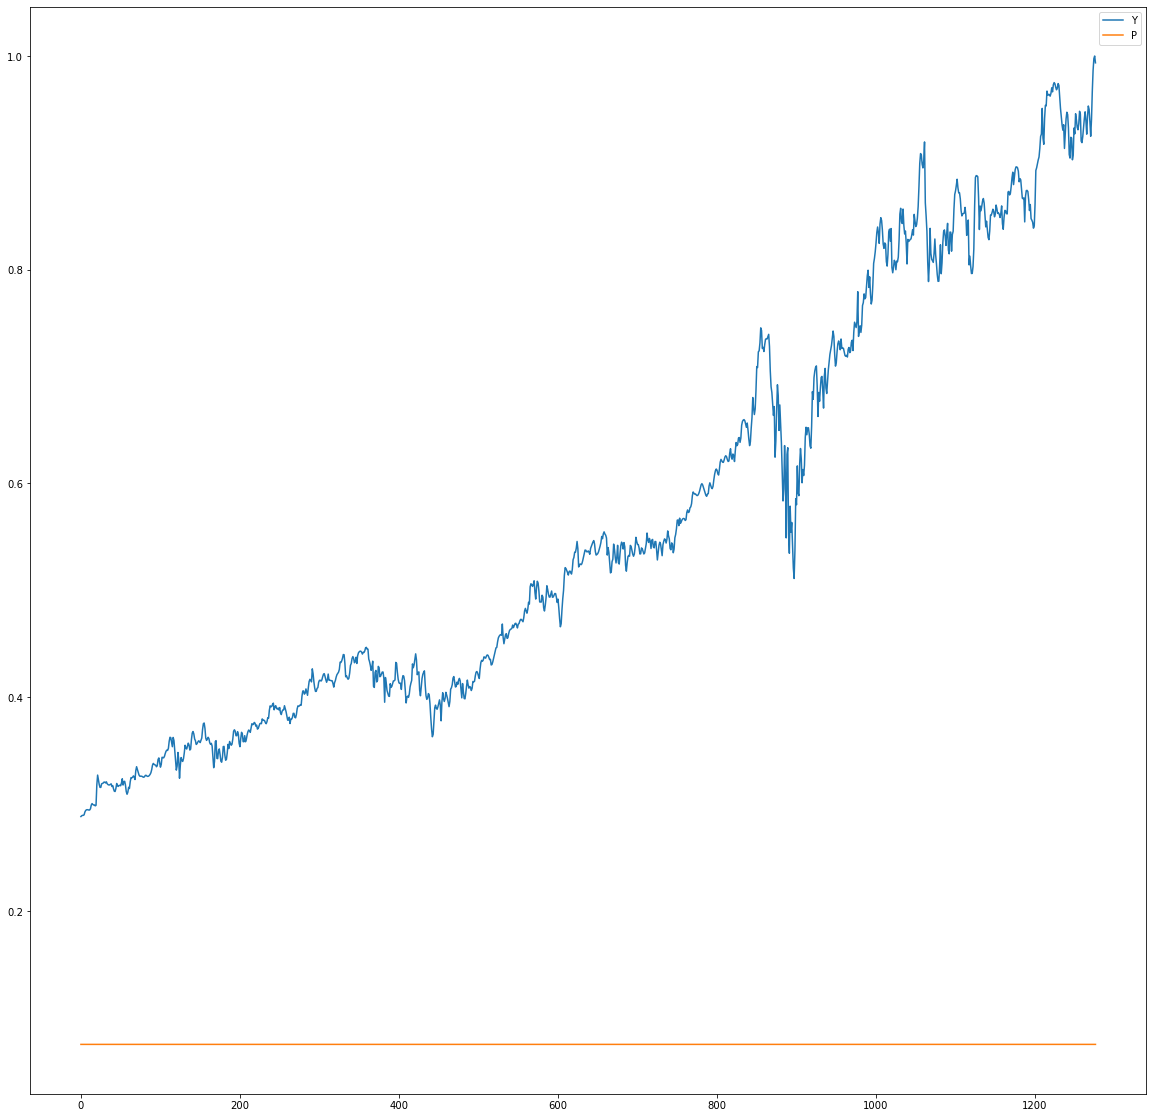

In [36]:
predictions=model.predict(vx)
# print("outputShape",predictions.shape)
# vEvals=model.evaluate(vx,vy,verbose=0)
# # print("Val Loss:",vEvals[0],"\tVal MAE:",vEvals[1])
# plotCompare(vy[:,-1],predictions[:,-1],["Y","P"])
# predictions=model.predict(tx)
# tEvals=model.evaluate(tx,ty,verbose=0)
# print("Test Loss:",tEvals[0],"\tTest MAE:",tEvals[1])
for l in range(0,lookAhead):
    plotCompare(ty[:,l],predictions[:,l],["Y","P"])

In [37]:
predictions=model.predict(vx)
vEvals=model.evaluate(vx,vy,verbose=0)
# rrr=0
# shiftff=5
# plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],5)
plotVisual(vy,predictions,lookAhead)
# plotCompare(vy[:2,-1],predictions[:,-1])
# print(predictions[100:])

KeyboardInterrupt: 

In [165]:
predictions

array([[[0.0530149 ],
        [0.05071943],
        [0.05167709],
        [0.05409897],
        [0.05114173]],

       [[0.05299263],
        [0.04967366],
        [0.05103568],
        [0.05543127],
        [0.05225955]],

       [[0.05288807],
        [0.04985759],
        [0.05050865],
        [0.05509818],
        [0.05303594]],

       ...,

       [[0.05205163],
        [0.05204093],
        [0.05169999],
        [0.05157913],
        [0.05252136]],

       [[0.05188144],
        [0.05239845],
        [0.0520196 ],
        [0.05099894],
        [0.05220296]],

       [[0.05185751],
        [0.05236801],
        [0.05228233],
        [0.05104688],
        [0.05185184]]], dtype=float32)

### LSTM

In [357]:
# tf.config.optimizer.set_jit(True)
# tf.config.optimizer.set_experimental_options({"constant_folding":False,"loop_optimization":False,"function_optimization":True,"arithmetic_optimization":True})

In [374]:
tf.keras.backend.clear_session()
def BILSTM_model(inputShape,activation='relu',hidden=16, stateful=False):
    M = Sequential()
#     if stateful: M.add(Input(batch_input_shape=inputShape))
#     else: M.add(Input(shape=inputShape))
    M.add(LSTM(hidden,activation='elu' ,kernel_regularizer=tf.keras.regularizers.L2(l2=0.5),return_sequences=True,stateful=stateful))
    M.add(LSTM(hidden,activation='elu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.2),return_sequences=True,stateful=stateful))
    M.add(LSTM(hidden,activation='elu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.1),return_sequences=False,stateful=stateful))
    M.add(Dense(lookAhead,kernel_initializer=tf.initializers.zeros()))
    M.add(Reshape([lookAhead, 1]))
    return M
model=BILSTM_model(inputShape=trainx.shape[1:],activation='relu',hidden=75*5,stateful=False)
# model.summary()
history=compileFit(model,optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),shuffle=False,batch_size=100,patience=1,loss="mse")
# model.save("BILSTM_model")
# model=tf.keras.models.load_model('BILSTM_model')


Epoch 1/100
103/103 [==============================] - 7s 34ms/step - loss: 158.7878 - val_loss: 102.7766
Epoch 2/100
103/103 [==============================] - 3s 29ms/step - loss: 89.4859 - val_loss: 56.6104
Epoch 3/100
103/103 [==============================] - 3s 29ms/step - loss: 48.8937 - val_loss: 30.0192
Epoch 4/100
103/103 [==============================] - 3s 30ms/step - loss: 25.6777 - val_loss: 15.2225
Epoch 5/100
103/103 [==============================] - 3s 30ms/step - loss: 12.8762 - val_loss: 7.3418
Epoch 6/100
103/103 [==============================] - 3s 29ms/step - loss: 6.1317 - val_loss: 3.3545
Epoch 7/100
103/103 [==============================] - 3s 29ms/step - loss: 2.7601 - val_loss: 1.4493
Epoch 8/100
103/103 [==============================] - 3s 29ms/step - loss: 1.1699 - val_loss: 0.5941
Epoch 9/100
103/103 [==============================] - 3s 29ms/step - loss: 0.4659 - val_loss: 0.2350
Epoch 10/100
103/103 [==============================] - 3s 29ms/step - 

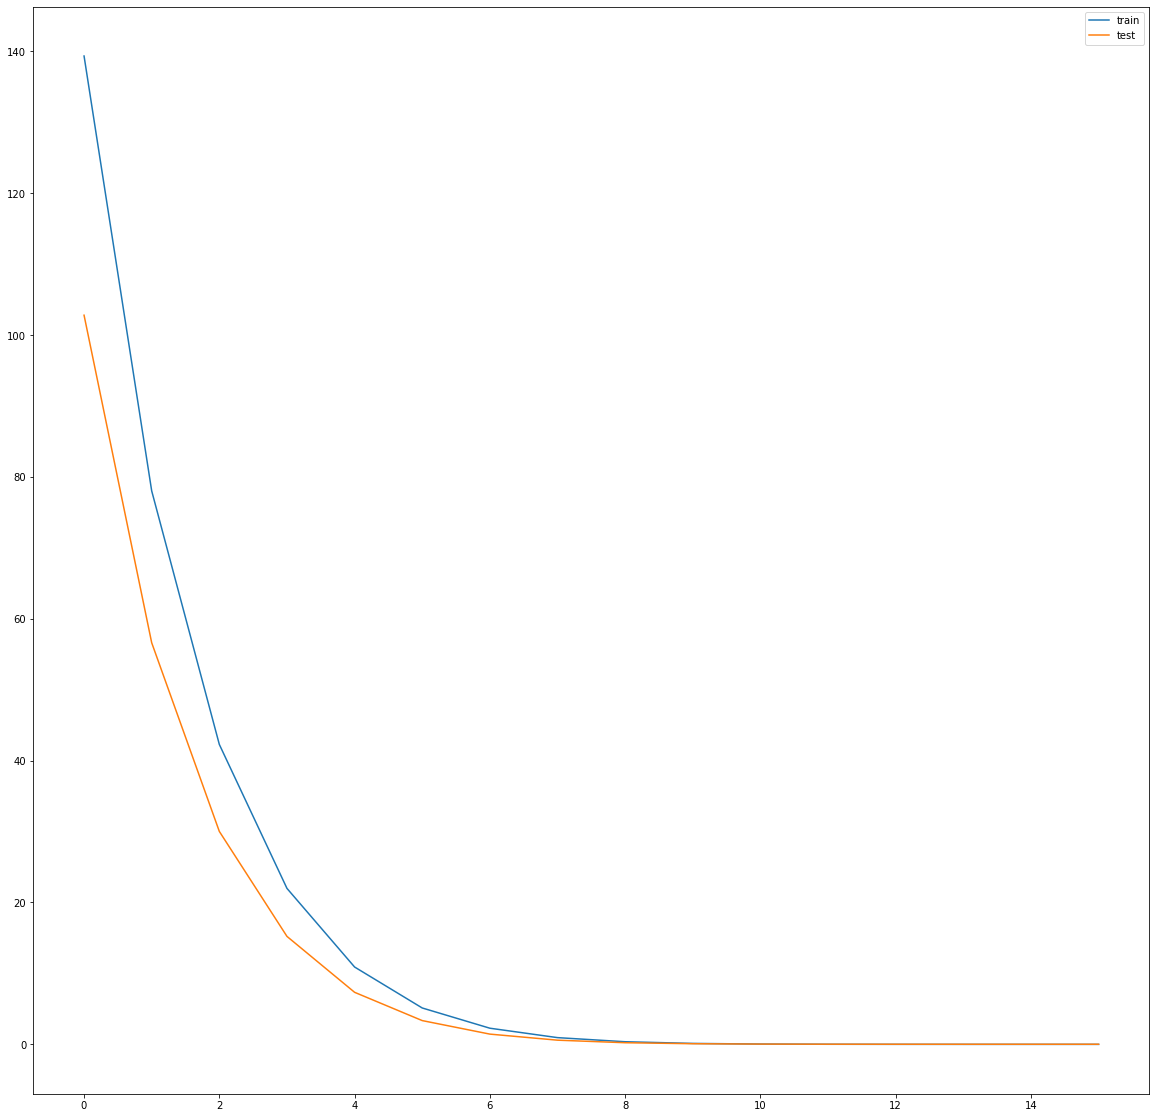

outputShape (1277, 5, 1)


In [377]:
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
plt.show()
predictions=model.predict(vx)
print("outputShape",predictions.shape)

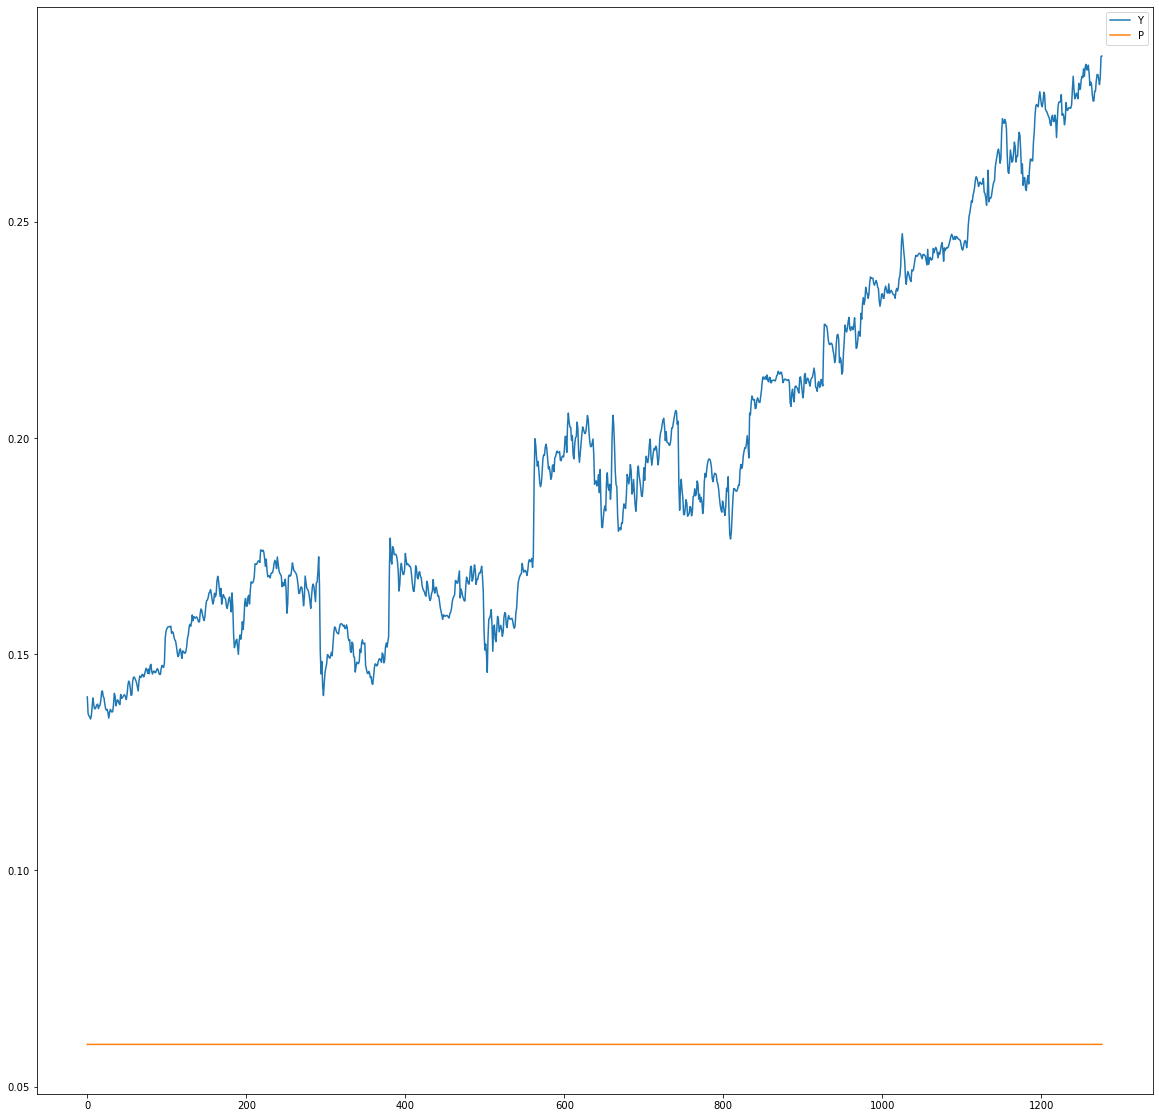

In [383]:
# vEvals=model.evaluate(vx,vy,verbose=0)
predictions=model.predict(vx)
# print("Val Loss:",vEvals[0],"\tVal MAE:",vEvals[1])
plotCompare(vy[:,-1],predictions[:,-1],["Y","P"])
# predictions=model.predict(tx)
# tEvals=model.evaluate(tx,ty,verbose=0)
# print("Test Loss:",tEvals[0],"\tTest MAE:",tEvals[1])
# plotCompare(ty[:,-1],predictions[:,-1],["Y","P"])

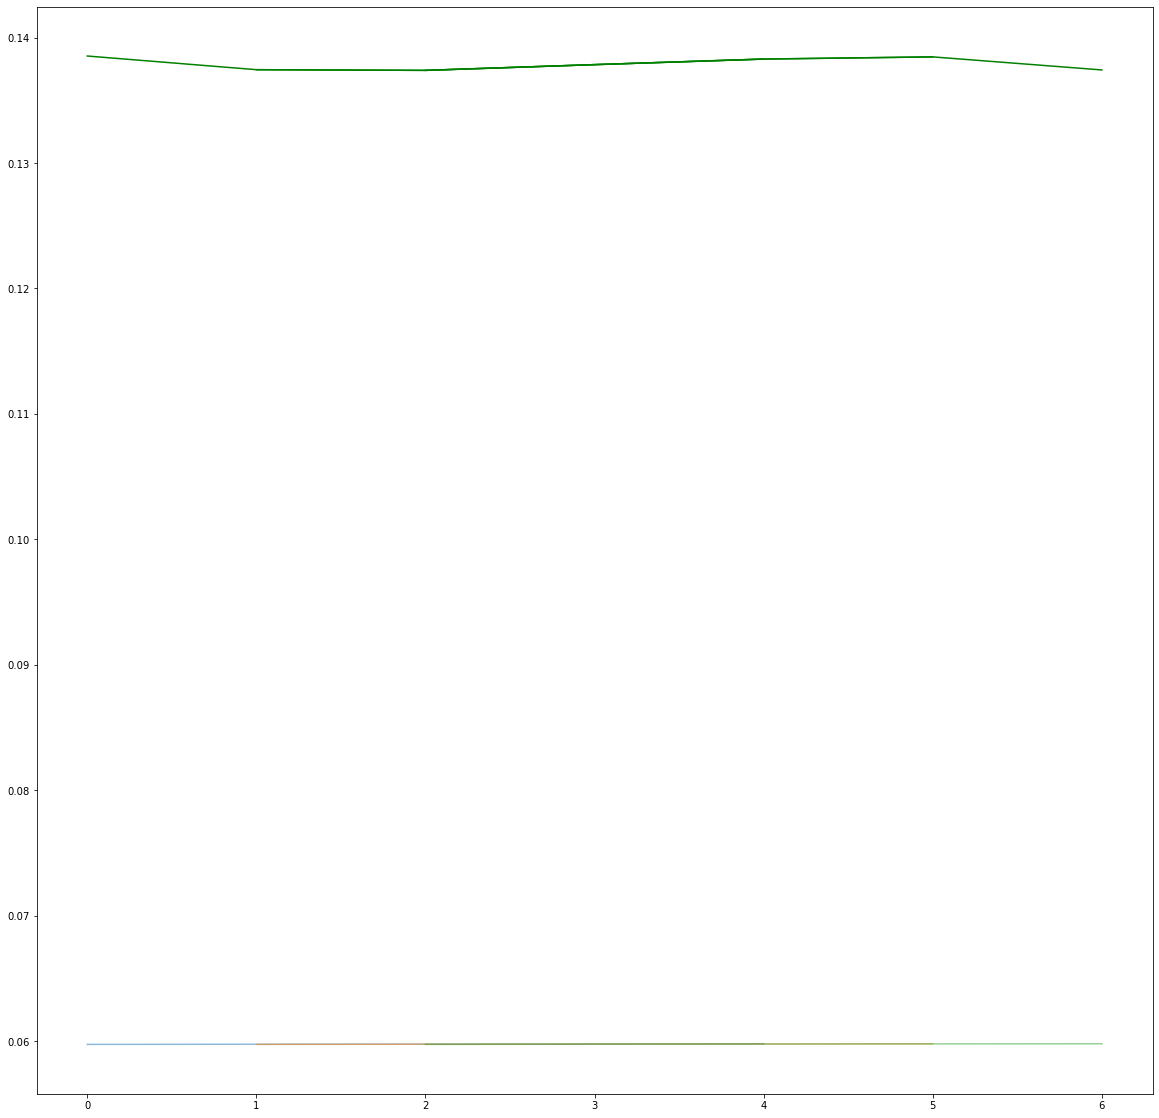

In [384]:
# predictions=model.predict(vx)
# vEvals=model.evaluate(tx,v,verbose=3)
# rrr=12
shiftff=3
plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],5)


### RESLSTM

In [137]:
def LSTM_model(inputShape, hidden=16):
    x = Input(shape=inputShape)
    E = ScalerMult(inputShape)(x)
    P = PositionalEncoding(inputShape[0], inputShape[1])(E)
    AT = MultiHeadAttention(num_heads=inputShape[0], key_dim=100)(P, P, P)
    AD1 = Add()([AT, P])
    NORM1 = LayerNormalization(axis=1)(AD1)
    FF = Dense(hidden, 'relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.5))(NORM1)
    FF = Dense(2, 'relu')(FF)
    AD2 = Add()([FF, NORM1])
    NORM2 = LayerNormalization(axis=1)(AD2)
    out = Dense(hidden, 'relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.1))(NORM2)
    out = Dense(1, 'linear')(out)
    M = tf.keras.models.Model(inputs=x, outputs=out)
    return M


model = LSTM_model(trainx.shape[1:], 600)
model.summary()

history = compileFit(model,
                     loss='huber',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
                     patience=5,
                     shuffle=True,
                     batch_size=200)

NameError: name 'ScalerMult' is not defined

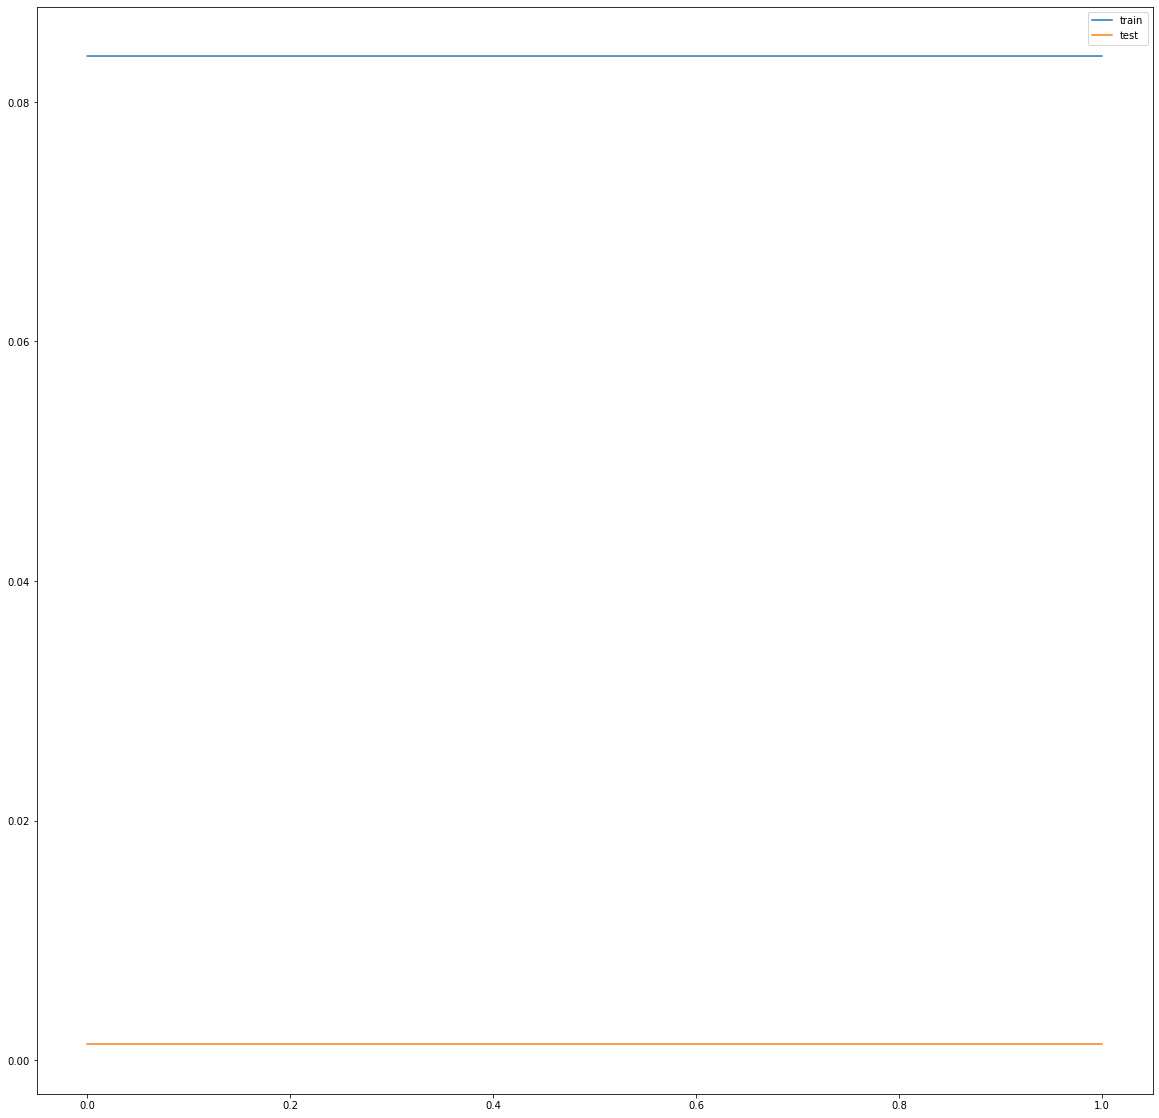

outputShape (1277, 5, 1)


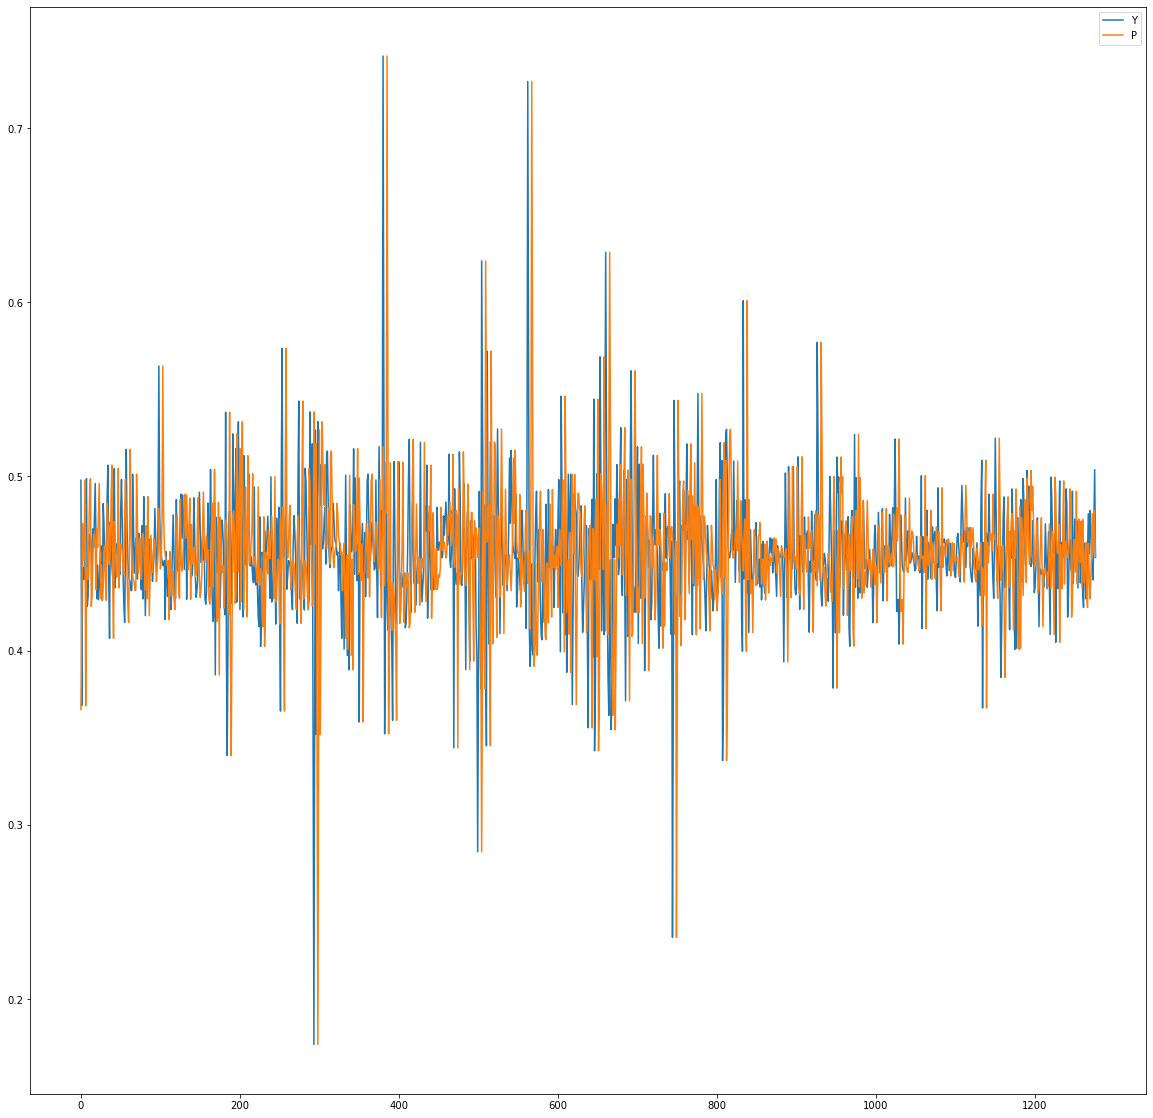

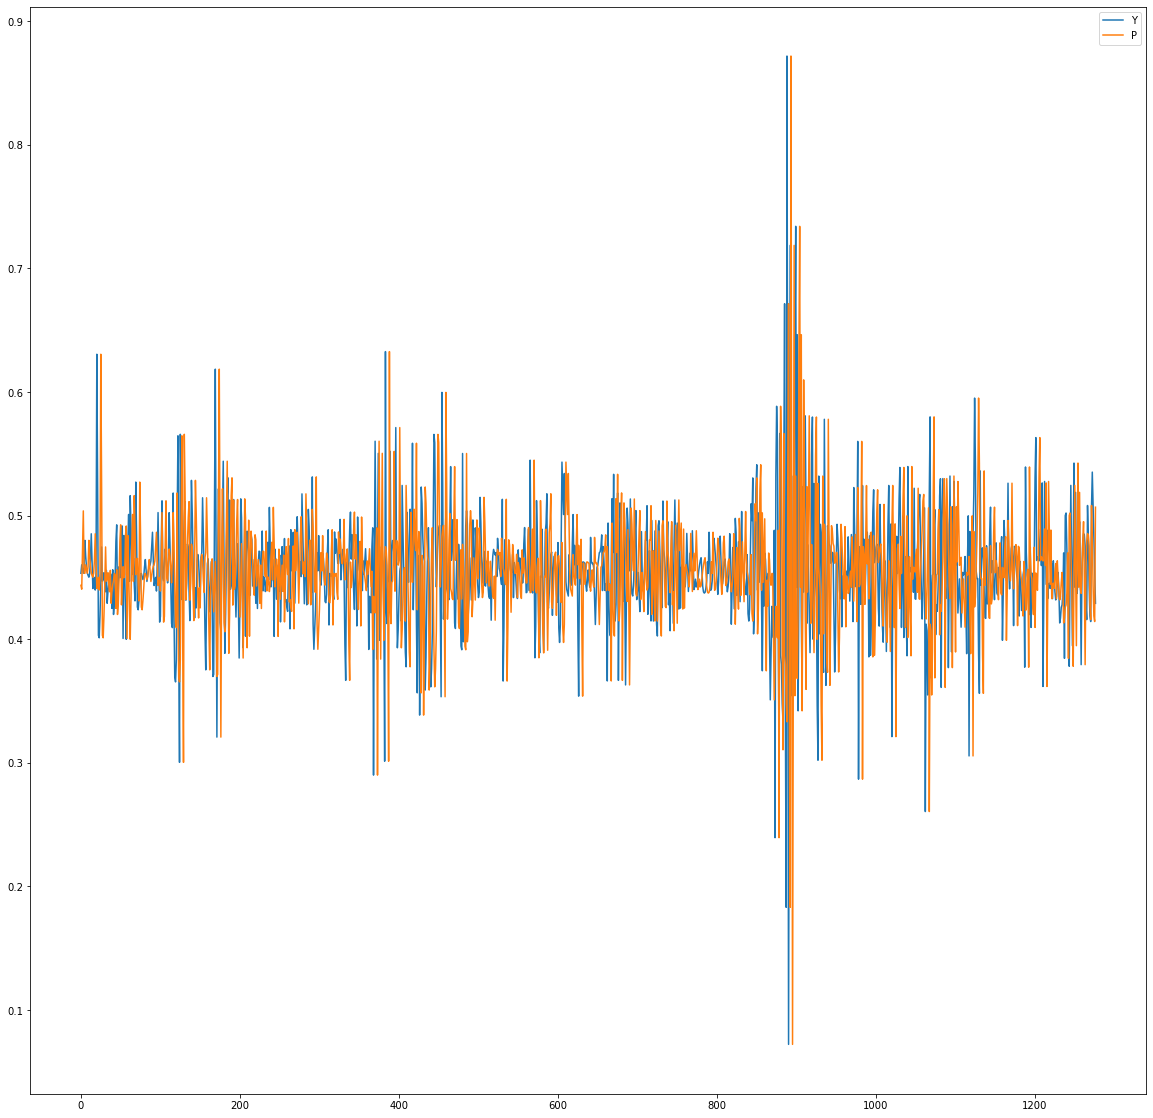

In [79]:
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
print("outputShape",predictions.shape)
predictions=model.predict(vx)
vEvals=model.evaluate(vx,vy,verbose=0)

# print("Val Loss:",vEvals[0],"\tVal MAE:",vEvals[1])
plotCompare(vy[:,-1],predictions[:,-1],["Y","P"])
predictions=model.predict(tx)
tEvals=model.evaluate(tx,ty,verbose=0)
# print("Test Loss:",tEvals[0],"\tTest MAE:",tEvals[1])
plotCompare(ty[:,-1],predictions[:,-1],["Y","P"])
plotVisual(vy,predictions,5)

Epoch 1/100
1022/1022 [==============================] - 5s 4ms/step - loss: 31661.6812 - val_loss: 7.6010
Epoch 2/100
1022/1022 [==============================] - 3s 3ms/step - loss: 35863.2478 - val_loss: 7.5980
Epoch 3/100
1022/1022 [==============================] - 3s 3ms/step - loss: 40638.9864 - val_loss: 7.5960
Epoch 4/100
1022/1022 [==============================] - 3s 3ms/step - loss: 35460.8593 - val_loss: 7.5949
Epoch 5/100
1022/1022 [==============================] - 3s 3ms/step - loss: 39723.9684 - val_loss: 7.5957
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 5, 1)]       0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 32)          

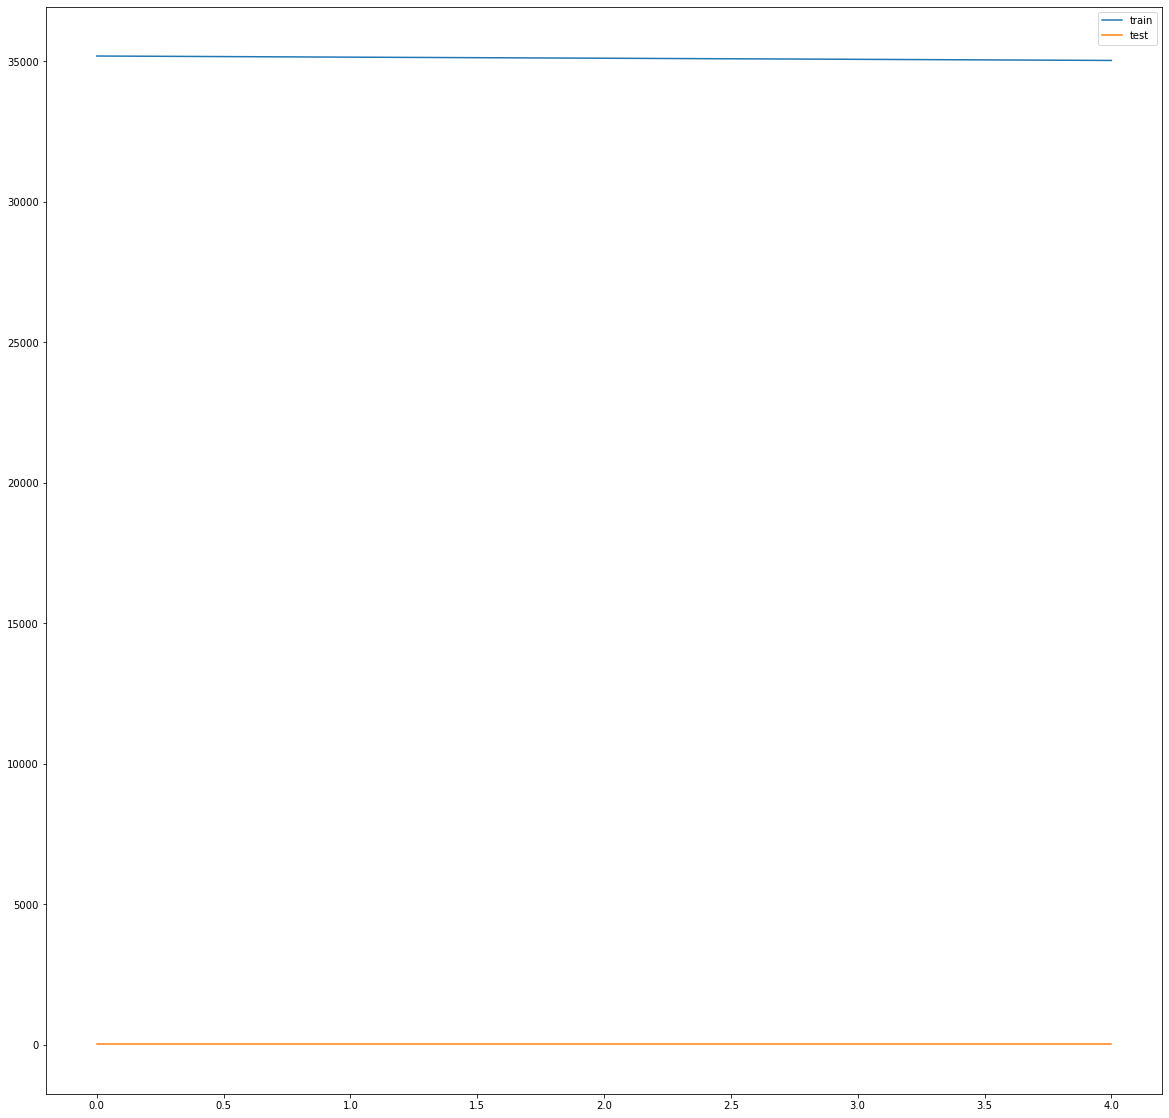

In [141]:
def RESLSTM(shape):
    x = Input(shape=shape)
    y = LSTM(32, return_sequences=False)(x)
    D = Dense(5, kernel_initializer=tf.initializers.zeros(), activation="relu")(y)
    D = Dense(5, kernel_initializer=tf.initializers.zeros())(D)
    D = Reshape([5, 1])(D)
    out = Add()([x, D])
    return tf.keras.models.Model(inputs=x, outputs=out)

model = RESLSTM(shape=vx.shape[1:])
history = compileFit(model,loss='mean_absolute_percentage_error',optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),patience=0,shuffle=True,batch_size=10)
# model.save("RESLSTM"
# model=tf.keras.models.load_model('RESLSTM')
# tf.keras.utils.plot_model(model)
model.summary()
plotCompare(history.history['loss'], history.history['val_loss'], ["train", "test"])

In [146]:
predictions=model.predict(vx)
print("outputShape",predictions.shape)
vEvals=model.evaluate(vx,vy,verbose=0)
# print("Val Loss:",vEvals[0],"\tVal MAE:",vEvals[1])
# plotCompare(vy[:,-1],predictions[:,-1],["Y","P"])
# predictions=model.predict(tx)
# tEvals=model.evaluate(tx,ty,verbose=0)
# # print("Test Loss:",tEvals[0],"\tTest MAE:",tEvals[1])
# plotCompare(ty[:,-1],predictions[:,-1],["Y","P"])

outputShape (1277, 5, 1)


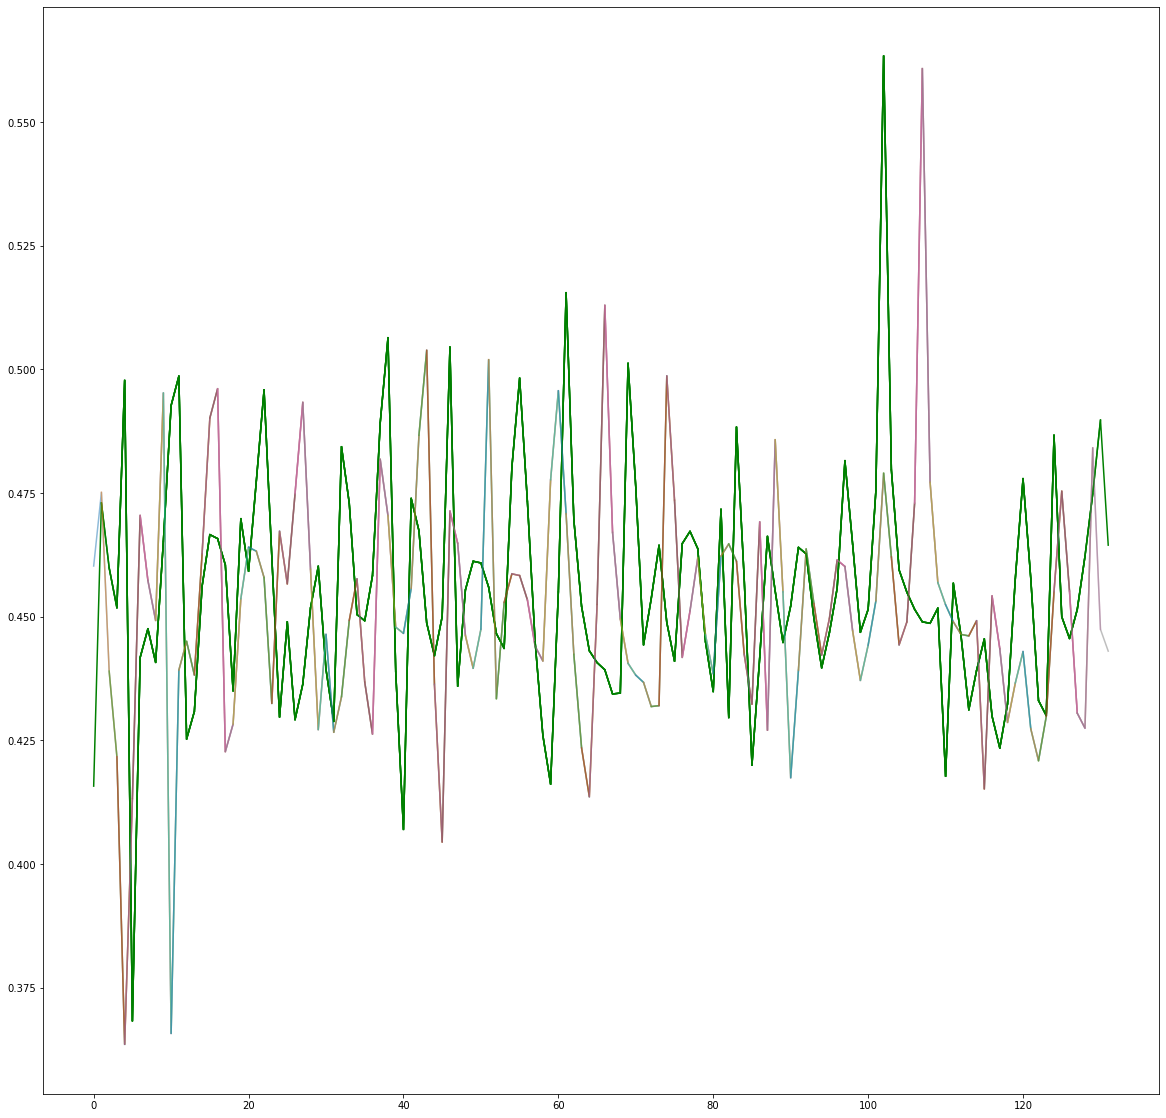

KeyboardInterrupt: 

In [147]:
plotVisual(vy,predictions,lookAhead)

[0.0035539248, 0.003553998, 0.003556946, 0.0035587891, 0.003560258]

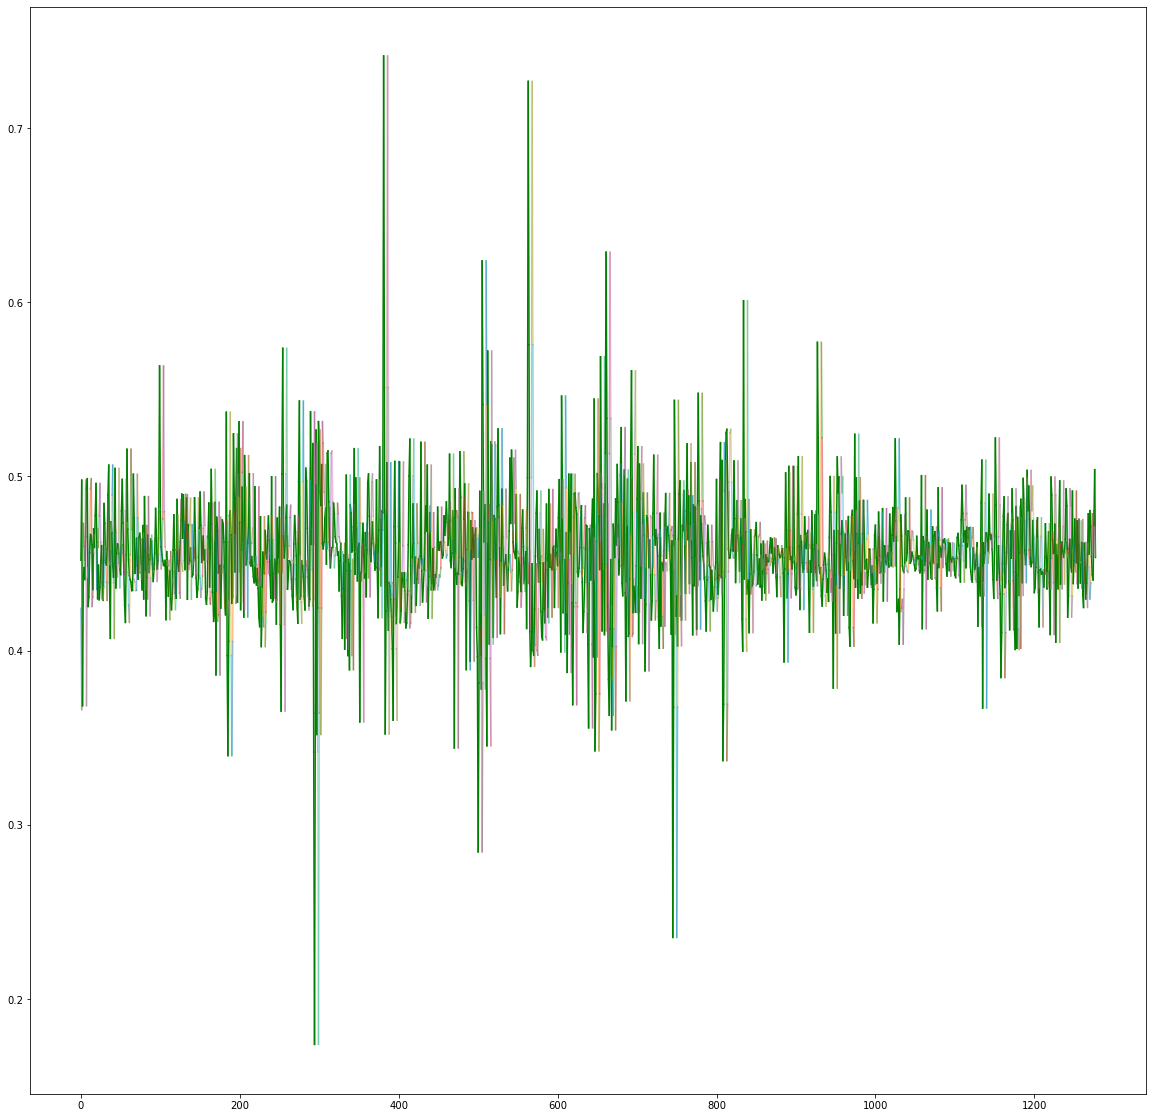

7.60611629486084

In [127]:
predictions=model.predict(vx)
vEvals=model.evaluate(vx,vy,verbose=0)
plotMultVariate(vy[:,-2:],predictions[:,-2:],2)
vEvals

### BILSTM

In [ ]:
tf.keras.backend.clear_session()
def BILSTM_model(inputShape,activation='relu',lstm=16,hidden=16, stateful=False):
    M = Sequential()
    if stateful: M.add(Input(batch_input_shape=inputShape))
    else: M.add(Input(shape=inputShape))
    M.add(Bidirectional(LSTM(lstm, activation="relu",return_sequences=True,stateful=stateful)))
    M.add(Bidirectional(LSTM(lstm, activation="relu",stateful=stateful)))
    M.add(Dense(5))
    return M

model=BILSTM_model(inputShape=(5,1),activation='relu',lstm=300,hidden=16,stateful=False)
history=compileFit(model,loss='huber',optimizer=SGD(lr=0.001, momentum=0.8),shuffle=True,batch_size=75,patience=3)
# plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
# model.save("BILSTM_model")
# model=tf.keras.models.load_model('BILSTM_model')
model.summary()

In [ ]:
predictions=model.predict(vx)
plotCompare(vy[:,-1],predictions[:,-1],["Y","P"])

### LSTM

In [259]:
predictions=model.predict(vx,batch_size=75)
plotCompare(vy.values[:,-1],predictions[:,-1],["Y","P"])

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [194]:
model.predict(vx[:-10])

array([[35.4782  ],
       [35.47349 ],
       [35.469997],
       ...,
       [35.15849 ],
       [35.158146],
       [35.158047]], dtype=float32)

### ConvLSTM

Epoch 1/100
10215/10215 [==============================] - 69s 7ms/step - loss: 0.0019 - val_loss: 0.0934
Epoch 2/100
10215/10215 [==============================] - 68s 7ms/step - loss: 0.0013 - val_loss: 0.0885
Epoch 3/100
10215/10215 [==============================] - 67s 7ms/step - loss: 0.0011 - val_loss: 0.0850
Epoch 4/100
10215/10215 [==============================] - 67s 7ms/step - loss: 8.3706e-04 - val_loss: 0.0831
Epoch 5/100
10215/10215 [==============================] - 67s 7ms/step - loss: 8.0847e-04 - val_loss: 0.0824
Epoch 6/100
10215/10215 [==============================] - 67s 7ms/step - loss: 8.0317e-04 - val_loss: 0.0822
Epoch 7/100
10215/10215 [==============================] - 67s 7ms/step - loss: 8.0884e-04 - val_loss: 0.0821
Epoch 8/100
10215/10215 [==============================] - 67s 7ms/step - loss: 7.9722e-04 - val_loss: 0.0821
Epoch 9/100
10215/10215 [==============================] - 67s 7ms/step - loss: 7.9670e-04 - val_loss: 0.0821
Epoch 10/100
10215/102

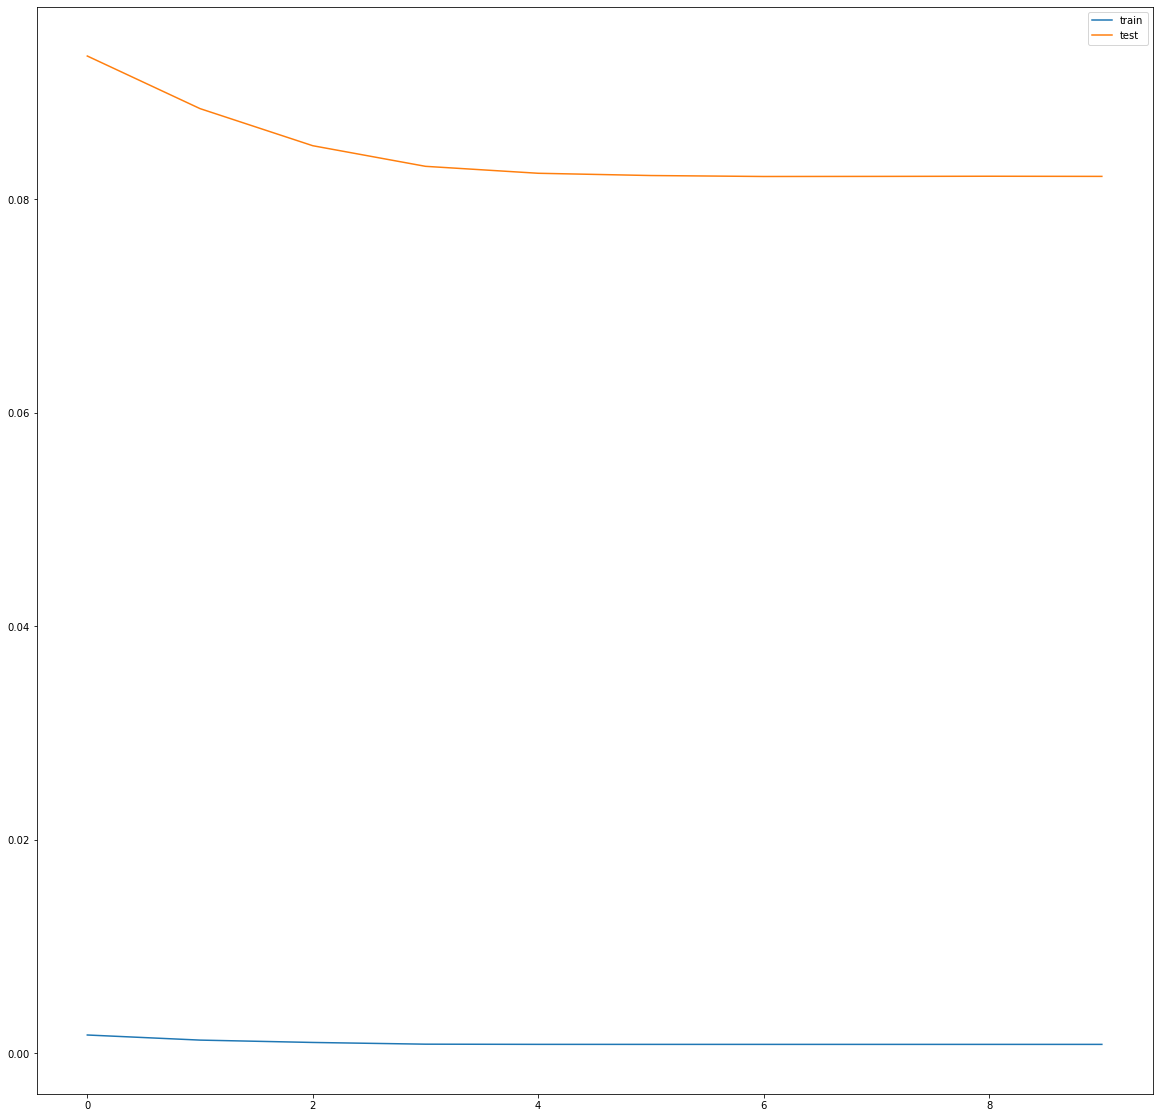

INFO:tensorflow:Assets written to: CovLSTM_model\assets


INFO:tensorflow:Assets written to: CovLSTM_model\assets


In [162]:
tf.keras.backend.clear_session()
def CovLSTM_model(inputShape,activation='relu',lstm=16,hidden=16):
    M = Sequential()
    M.add(Input(shape=inputShape))
    M.add(Conv1D(filters=32, kernel_size=2,strides=1,padding="causal",activation="relu"))
    M.add(LSTM(lstm,LeakyReLU(),return_sequences=False))
    M.add(Dense(5, LeakyReLU()))
    M.add(Reshape([5, 1]))
    return M
# losses 'mean_squared_logarithmic_error','mean_squared_error',
#        'mean_absolute_error' "huber"
#    
model=CovLSTM_model(inputShape=(5,1),activation='relu')
history=compileFit(model,loss='huber',optimizer=SGD(lr=0.0001, momentum=0.8),shuffle=True,batch_size=1,patience=3)
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
model.save("CovLSTM_model")
# model=tf.keras.models.load_model('CovLSTM_model')

In [ ]:
predictions=model.predict(vx,batch_size=1)
plotCompare(vy.values,predictions[:,-1],["Y","P"])

### DNN

In [128]:
def plotCompare(x,y,labels=None,size=(20,10)):
    if labels is None:
        labels=["X,Y"]
    plt.plot(x, label=labels[0])
    plt.plot(y, label=labels[1])
    plt.legend()
    plt.show()

In [133]:
tf.keras.backend.clear_session()
def DNN_model(inputShape,activation='relu',lstm=16,hidden=16, stateful=False):
    M = Sequential()
    M.add(Input(shape=inputShape))
    M.add(Dense(512, kernel_regularizer=tf.keras.regularizers.L2(l2=0.2), activation="elu"))
    M.add(Dropout(0.2))
    M.add(Dense(512, kernel_regularizer=tf.keras.regularizers.L2(l2=0.1), activation="elu"))
    M.add(Dense(1, activation="relu"))
    M.add(Reshape([5,1]))
#     
    return M
# losses 'mean_squared_logarithmic_error','mean_squared_error',
#        'mean_absolute_error' "huber" 
model=DNN_model(inputShape=trainx.shape[1:],activation='relu',hidden=20)
history=compileFit(model,loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),epochs=10000,batch_size=75,patience=1)
# model.save("DNN_model")
# model=tf.keras.models.load_model('DNN_model')
model.summary()

Epoch 1/10000
137/137 [==============================] - 1s 5ms/step - loss: 45.2732 - val_loss: 29.7840
Epoch 2/10000
137/137 [==============================] - 0s 4ms/step - loss: 25.8753 - val_loss: 16.7245
Epoch 3/10000
137/137 [==============================] - 0s 4ms/step - loss: 14.3581 - val_loss: 9.0821
Epoch 4/10000
137/137 [==============================] - 0s 3ms/step - loss: 7.6642 - val_loss: 4.7623
Epoch 5/10000
137/137 [==============================] - 0s 3ms/step - loss: 3.9076 - val_loss: 2.4154
Epoch 6/10000
137/137 [==============================] - 0s 3ms/step - loss: 1.8913 - val_loss: 1.2048
Epoch 7/10000
137/137 [==============================] - 0s 3ms/step - loss: 0.8643 - val_loss: 0.6146
Epoch 8/10000
137/137 [==============================] - 0s 3ms/step - loss: 0.3715 - val_loss: 0.3479
Epoch 9/10000
137/137 [==============================] - 0s 3ms/step - loss: 0.1499 - val_loss: 0.2355
Epoch 10/10000
137/137 [==============================] - 0s 3ms/ste

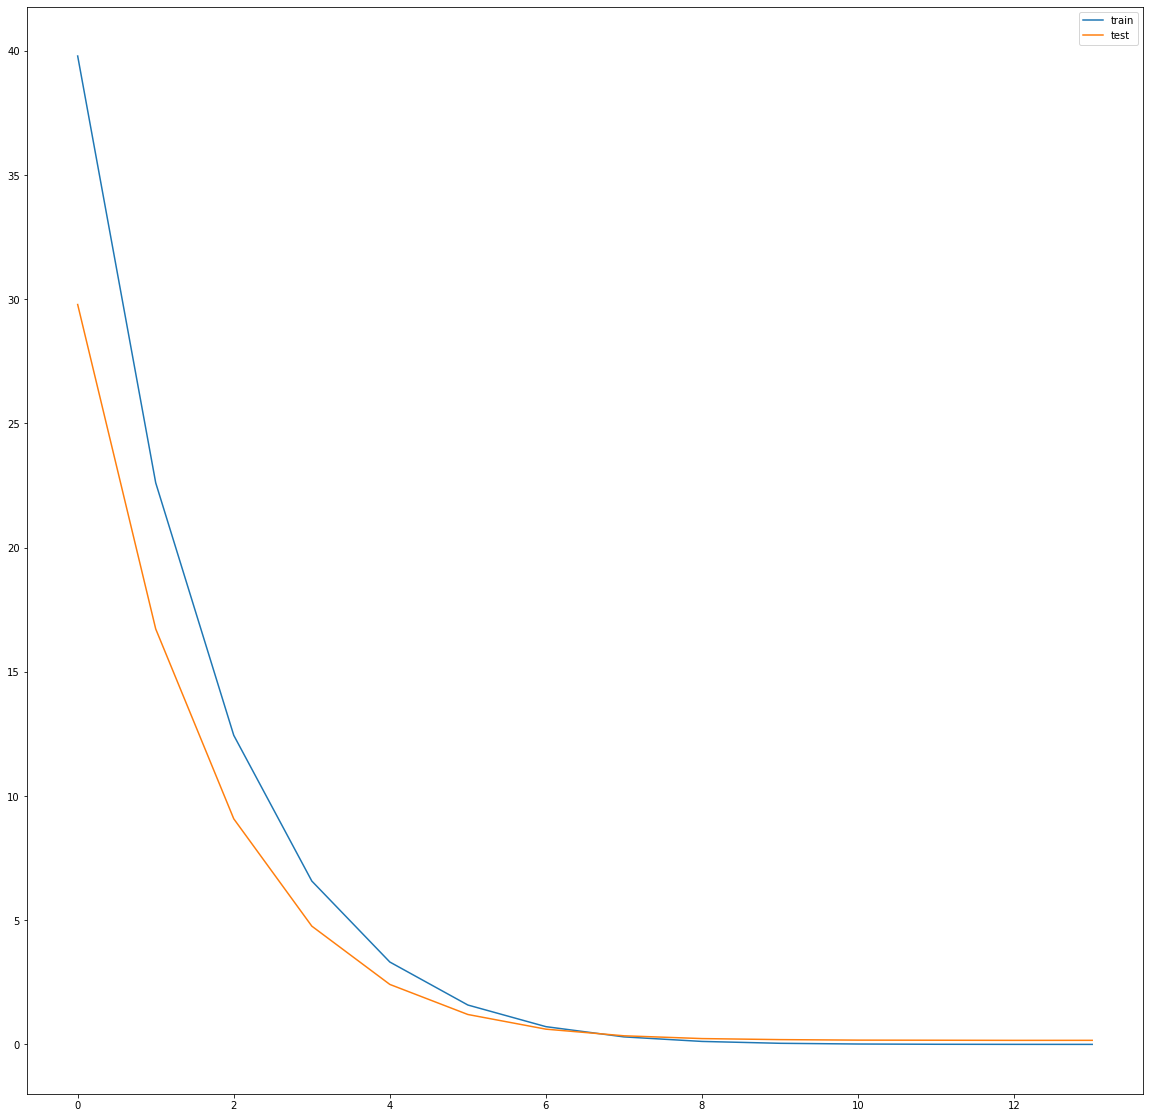

outputShape (1277, 5, 1)
Writing 'vEvals' (float) to file 'a.txt'.


TypeError: 'float' object is not subscriptable

In [134]:
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
print("outputShape",predictions.shape)
predictions=model.predict(vx)
vEvals=model.evaluate(vx,vy,verbose=0)
%store vEvals >>a.txt
print("Val Loss:",vEvals[0],"\tVal MAE:",vEvals[1])
plotCompare(vy[:,-1],predictions[:,-1],["Y","P"])
predictions=model.predict(tx)
tEvals=model.evaluate(tx,ty,verbose=0)
print("Test Loss:",tEvals[0],"\tTest MAE:",tEvals[1])
plotCompare(ty[:,-1],predictions[:,-1],["Y","P"])

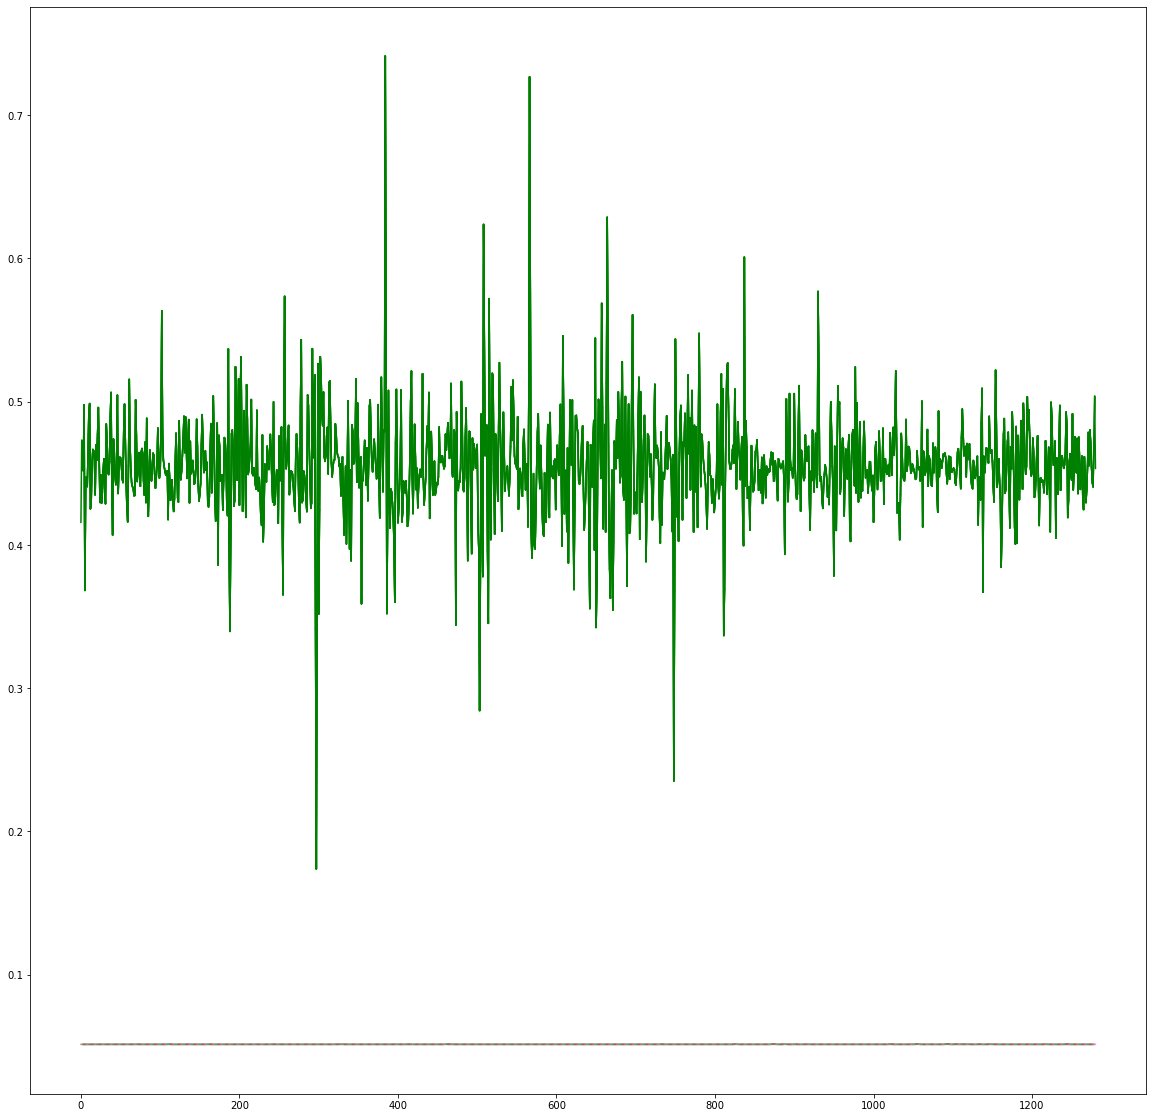

In [135]:
predictions=model.predict(vx)
vEvals=model.evaluate(vx,vy,verbose=0)
plotMultVariate(vy,predictions,5)

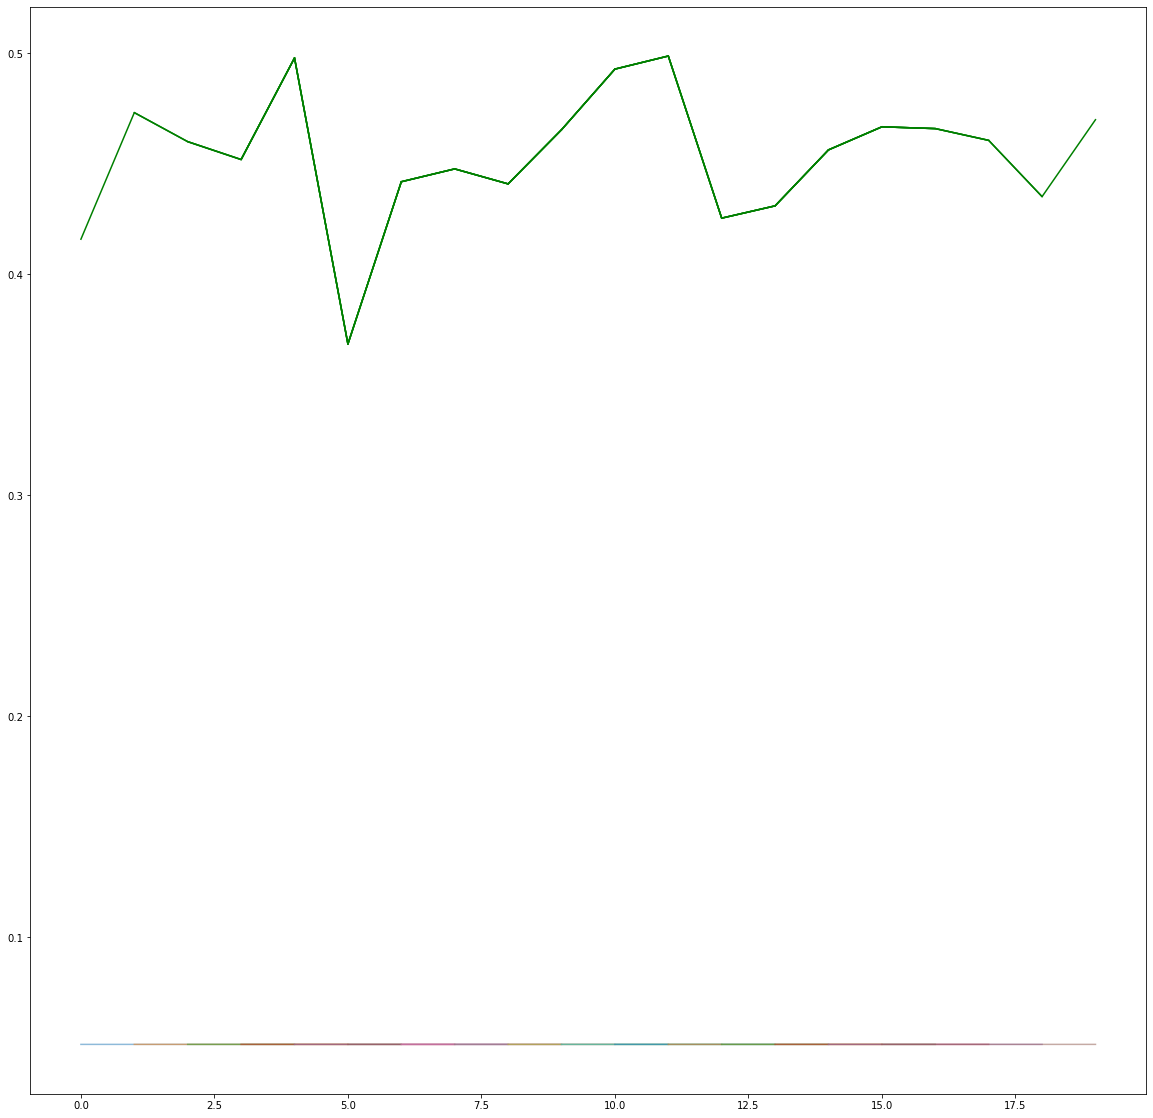

KeyboardInterrupt: 

In [136]:
plotVisual(vy,predictions,5)
# iiii=9
# plt.plot(range(iiii,iiii+5),vy[iiii],range(iiii,iiii+5),predictions[iiii])

### Positional Encoding

In [95]:
# s=50
# plt.plot(vy[:s])
# for v in range(0,len(predictions[:s])-period):
#     plt.plot(vy.index[v+1:v+period+1],predictions[v])
#     print(v,v+period,v)

In [96]:
def predict_N_Days(model,data,days=5):
    shift=len(data)
    data=data.flatten()
    for i in range(days):
        prediction=model.predict(data[i:].reshape(1,shift,-1))[:,-1]
        data=np.append(data,prediction)
    return data[shift:]
def predict_N_Days_N_Samples(model,data,shifts=5):
    shift=len(data)*[None]
    for i in range(len(shift)):
        shift[i]=predict_N_Days(model,data[i],shifts)
    return shift

days=2
samples=10
# ps=predict_N_Days_N_Samples(model,vx[:samples],days)
p=predict_N_Days(model,vx[0],days=5)
plt.plot(vy["Close"][:samples+days])
# for v in range(samples): plt.plot(vy.index[v:v+days],ps[v][-1])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

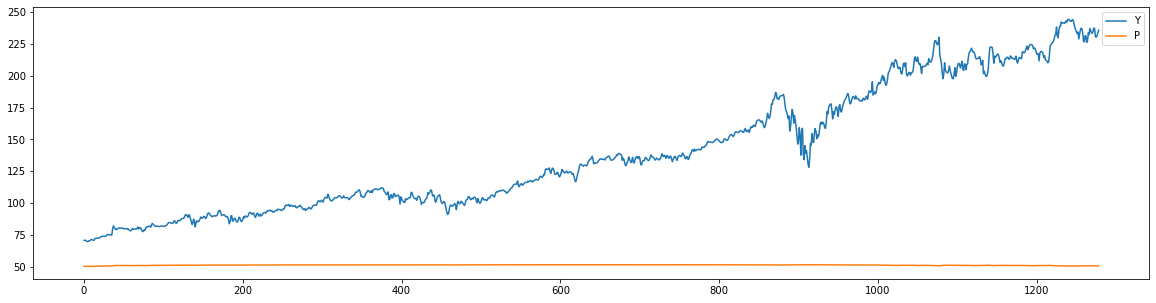

In [1537]:
predictions=model.predict(tx)
plotCompare(ty.values,predictions[:,-1],["Y","P"])

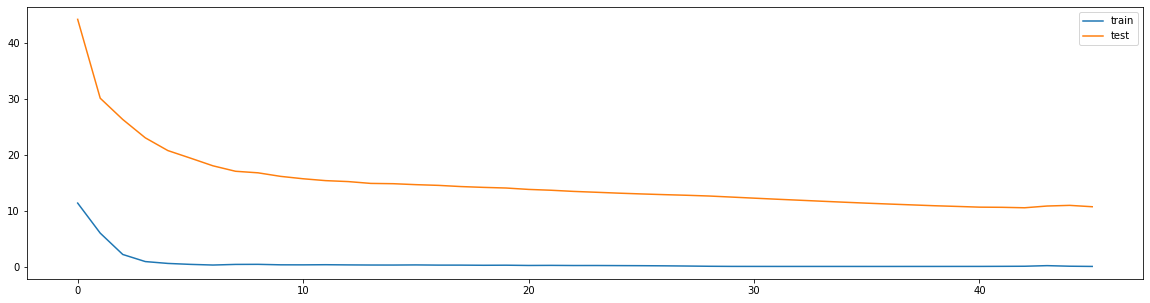

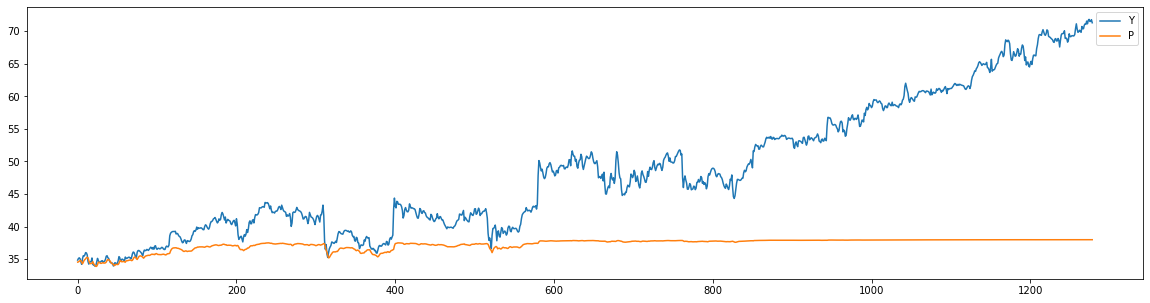

# Applying Sentiment to our models 

In [126]:
# insterDFToDB("processedSentiment140",sentiment140Value[["_id","SentimentScore","processed"]])

In [47]:
tweetdata

,body
post_date,
2015-01-01,"lx21 made $10,008 on $AAPL -Check it out! htt..."
2015-01-01,Insanity of today weirdo massive selling. $aap...
2015-01-01,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...
2015-01-01,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...
2015-01-01,Swing Trading: Up To 8.91% Return In 14 Days h...
...,...
2019-12-31,That $SPY $SPX puuump in the last hour was the...
2019-12-31,In 2020 I may start Tweeting out positive news...
2019-12-31,Patiently Waiting for the no twitter sitter tw...


In [59]:
pss=pd.DataFrame(tweetdata["body"][tweetdata["body"].str.contains("tsla|tesla", case=False, flags=0, na=None, regex=True)].apply(preprocess))
pss=pss.drop_duplicates(subset=['body'], keep='last')
pss=pss.sample(frac=1)

In [67]:
pss["2015"].

KeyError: '2015'

In [64]:
pss.resample('D').first()
# data["wasNa"]=data['Close'].isna()#mark filled in spots for future reference
# print(data["wasNa"].value_counts())

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [73]:
model = Pipeline([
        ('bow', CountVectorizer(max_features=300000,preprocessor=preprocess,ngram_range=(1,2),lowercase=False)),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
    ])
    
model.fit(trainX.values, trainY[original3].values.flatten())
pred=model.predict(testX.values)
print(confusion_matrix(testY[original3].values,pred))
print(classification_report(testY[original3].values,pred))

[[125263  29085]
 [ 31272 120911]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.81    154348
           2       0.81      0.79      0.80    152183

    accuracy                           0.80    306531
   macro avg       0.80      0.80      0.80    306531
weighted avg       0.80      0.80      0.80    306531



In [75]:
pss

,body,sentiment
post_date,,
2016-04-15,crmd reviews updated friday april NUMBERTAG...,2
2019-01-11,service king in texas listed online as tesla ...,2
2018-09-13,indeed have warned investors to secure their ...,2
2017-07-06,HASHTAG shares down more than NUMBERTAG t...,2
2019-08-12,NUMBERTAG for pharma they label things as ...,2
...,...,...
2018-03-30,t securities lc purchases NUMBERTAG shares...,2
2017-12-22,HASHTAG subsidiary esteq investment and key...,2
2018-11-19,tfw you wake up with bad flu and someone tells...,-1


In [62]:
pss["sentiment"]=model.predict(pss["body"].values)

In [84]:
pss["sentiment"]=pss["sentiment"].replace({0:-1,2:1})

In [85]:
# pss.set_index(pd.to_datetime(pss.index, unit='d',utc=True).dt.date)

In [86]:
# TSLA=load("TSLA")
# TSLA=loadStockData(stock)
print(tweetdata.index.min(), tweetdata.index.max())
print(TSLA.index.min(), TSLA.index.max())
mini,maxi=None,None
if tweetdata.index.min()>TSLA.index.min(): mini=tweetdata.index.min()
else: mini= TSLA.index.min()
if tweetdata.index.max()>TSLA.index.max(): mini=TSLA.index.max()
else: maxi= tweetdata.index.max()
print(mini,"-",maxi)

2015-01-01 2019-12-31
2010-06-29 00:00:00 2021-03-31 00:00:00
2015-01-01 - 2019-12-31


In [4]:
# check if stock has relationship with sentiment
# check if sentiment compenent works well
# check if sentiment compenent improves stock predictions 
# check if fill in and check missing data in time series problems
# check how roll calculates missing values 

In [87]:
pss

,body,sentiment
post_date,,
2016-04-15,crmd reviews updated friday april NUMBERTAG...,1
2019-01-11,service king in texas listed online as tesla ...,1
2018-09-13,indeed have warned investors to secure their ...,1
2017-07-06,HASHTAG shares down more than NUMBERTAG t...,1
2019-08-12,NUMBERTAG for pharma they label things as ...,1
...,...,...
2018-03-30,t securities lc purchases NUMBERTAG shares...,1
2017-12-22,HASHTAG subsidiary esteq investment and key...,1
2018-11-19,tfw you wake up with bad flu and someone tells...,-1


In [72]:
# tslaTweets=tweetdata[tweetdata["body"].str.contains("tsla|tesla", case=False, na=None, regex=True)]
# tslaTweets["sentiment"]=model.predict(tslaTweets["body"])
# tslaTweets["good"],tslaTweets["bad"]=tslaTweets["sentiment"].apply(lambda x: x==4 and 1 or 0),tslaTweets["sentiment"].apply(lambda x: x==0 and 1 or 0)
# tslaTweets=tslaTweets.groupby(tslaTweets.index).sum()
# tslaTweets=tslaTweets.set_index(pd.to_datetime(tslaTweets.index))

<ipython-input-72-fedfca0b24ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tslaTweets["sentiment"]=model.predict(tslaTweets["body"])
<ipython-input-72-fedfca0b24ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tslaTweets["good"],tslaTweets["bad"]=tslaTweets["sentiment"].apply(lambda x: x==4 and 1 or 0),tslaTweets["sentiment"].apply(lambda x: x==0 and 1 or 0)


In [90]:
pss["good"],pss["bad"]=pss["sentiment"].apply(lambda x: x==1 and 1 or 0),pss["sentiment"].apply(lambda x: x==-1 and 1 or 0)
pss=pss.groupby(pss.index).sum()
pss=pss.set_index(pd.to_datetime(pss.index))
pss

,sentiment,good,bad
post_date,,,
2015-01-01,30,47,17
2015-01-02,38,99,61
2015-01-03,24,48,24
2015-01-04,24,56,32
2015-01-05,89,153,64
...,...,...,...
2019-12-27,378,821,443
2019-12-28,180,388,208
2019-12-29,149,372,223


In [129]:
pss["diff"]=pss["good"]-pss["bad"]
pss["str"]=pss["diff"]/(pss["good"]+pss["bad"])
pss["sign"]=np.sign(pss["diff"])
pss["change"]=(pss["diff"]-pss["diff"].shift(1)).fillna(0)
pss["changeS"]=np.sign(pss["change"])
pss=pss.resample('D').first()
pss=pss.ffill()

In [9]:
# tslaTweets
# findMissingInterval(tslaTweets)

In [10]:
# slices.drop(columns=['sentiment'], inplace=True)
tslaTweets["diff"]=tslaTweets["good"]-tslaTweets["bad"]
tslaTweets["str"]=tslaTweets["diff"]/(tslaTweets["good"]+tslaTweets["bad"])
tslaTweets["sign"]=np.sign(tslaTweets["diff"])
tslaTweets["change"]=(tslaTweets["diff"]-tslaTweets["diff"].shift(1)).fillna(0)
tslaTweets["changeS"]=np.sign(tslaTweets["change"])
tslaTweets=tslaTweets.resample('D').first()
tslaTweets=tslaTweets.ffill()

In [130]:
pss.index.max(),pss.index.min(),TSLA.index.max(),TSLA.index.min()

(Timestamp('2019-12-31 00:00:00', freq='D'),
 Timestamp('2015-01-01 00:00:00', freq='D'),
 Timestamp('2021-03-31 00:00:00'),
 Timestamp('2010-06-29 00:00:00'))

In [131]:
mini=pss.index.min()
maxi=pss.index.max()

<AxesSubplot:>

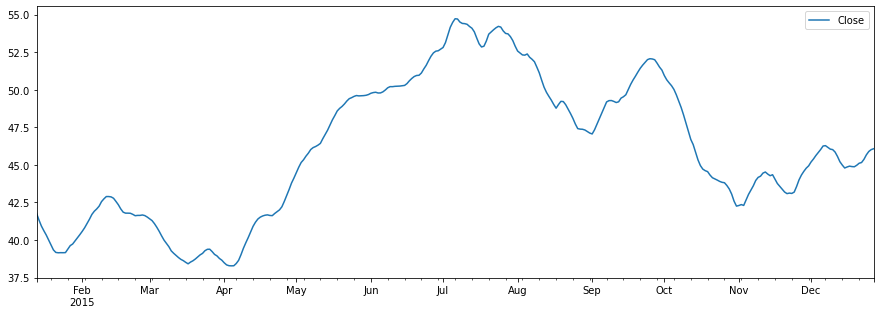

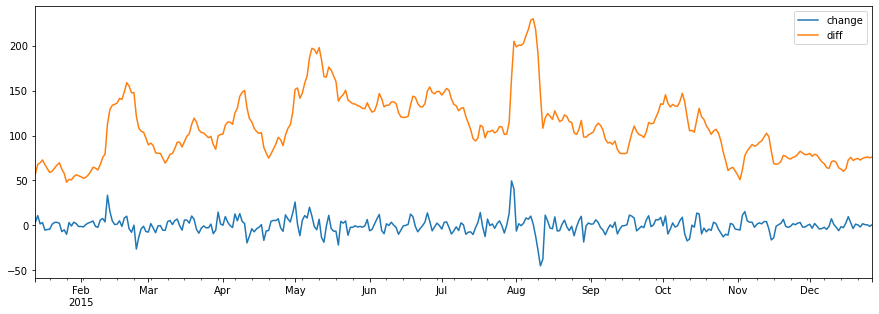

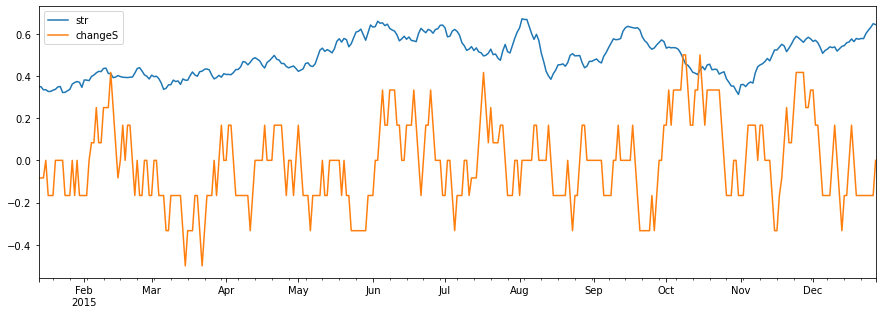

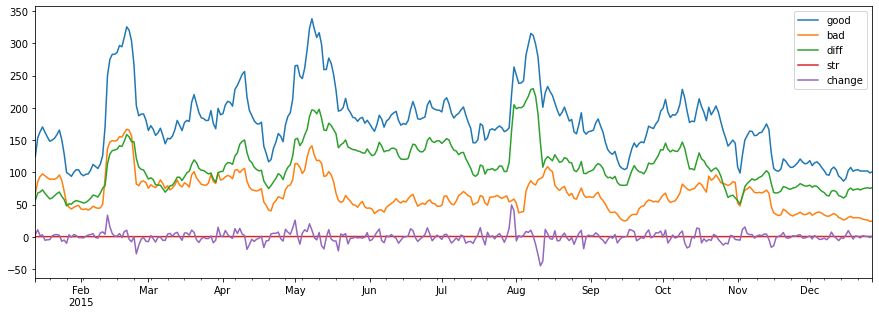

In [132]:
fromD=mini+ timedelta(days=12)
to=mini+ timedelta(days=360)
common=pd.merge(left=data, left_index=True, right=pss, right_index=True)
commonr=common.rolling(12).mean().dropna()
commonr[fromD:to][["Close"]].plot(xlim=(fromD,to))
commonr[fromD:to][["change","diff"]].plot(xlim=(fromD,to))
commonr[fromD:to][["str","changeS"]].plot(xlim=(fromD,to))
commonr[fromD:to][['good', 'bad', 'diff', 'str', 'change']].plot(xlim=(fromD,to))

In [134]:
commonr

,Open,High,Low,Close,Volume,wasNa,sentiment,good,bad,diff,str,sign,change,changeS
2015-01-12,42.608673,42.850898,41.427752,42.064669,2.488370e+07,0.416667,53.500000,103.250000,49.750000,53.500000,0.377193,1.0,6.083333,0.000000
2015-01-13,42.278797,42.562791,41.132752,41.774859,2.537677e+07,0.333333,57.000000,124.333333,67.333333,57.000000,0.349494,1.0,3.500000,-0.083333
2015-01-14,41.661464,42.095291,40.661752,41.331193,2.820489e+07,0.333333,67.916667,153.583333,85.666667,67.916667,0.348968,1.0,10.916667,-0.083333
2015-01-15,41.211381,41.669382,40.320188,40.933334,2.823104e+07,0.250000,69.666667,163.250000,93.583333,69.666667,0.334441,1.0,1.750000,-0.083333
2015-01-16,40.741399,41.259912,39.986114,40.625974,2.774917e+07,0.166667,72.833333,170.500000,97.666667,72.833333,0.334780,1.0,3.166667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,81.178957,82.770226,80.342156,81.995421,6.374007e+07,0.250000,365.500000,773.000000,407.500000,365.500000,0.318440,1.0,21.916667,0.000000
2019-12-28,82.478519,83.637071,81.345692,82.727754,6.056778e+07,0.333333,348.916667,722.583333,373.666667,348.916667,0.323954,1.0,-16.583333,-0.166667
2019-12-29,83.529353,84.448002,82.028269,83.365483,6.227617e+07,0.416667,338.000000,697.916667,359.916667,338.000000,0.322726,1.0,-10.916667,-0.166667
2019-12-30,84.332020,85.011003,82.506269,83.724650,6.163676e+07,0.416667,312.333333,660.166667,347.833333,312.333333,0.314640,1.0,-25.666667,-0.166667


# Results

In [18]:
# dataIn,dataOut=createTimeSeriesData(commonr[["Close","sentiment"]],outputColumns=["Close"],outputlengthTimeSteps=lookAhead,shifts=period)
# dataIn=(dataIn.to_numpy().reshape(dataIn.shape[0],period,-1))
# dataOut=(dataOut.to_numpy().reshape(dataOut.shape[0],lookAhead,-1))
# split=0.2
trainx,vtx,trainy,vty=train_test_split(dataIn,dataOut,test_size=split,shuffle=False)
vx,tx,vy,ty=train_test_split(vtx,vty,test_size=0.5,shuffle=False)
print("Total Samples:",len(dataIn),"\t\t\tTraining Samples:",len(trainx))
print("Total Validation Samples:",len(vy),"\t\tTest Samples:",len(ty))
print("Input Data Shape:",tx.shape[1:],"\t\tOutput Data Shape:",ty.shape[1:])

Total Samples: 12795 			Training Samples: 10236
Total Validation Samples: 1279 		Test Samples: 1280
Input Data Shape: (5, 1) 		Output Data Shape: (5, 1)


In [17]:
trainx,vtx,trainy,vty=train_test_split(data[:-1][["Close"]].values.reshape(-1,1,1),data[:-1][["Close"]].values.reshape(-1,1,1),test_size=0.2,shuffle=False)

In [23]:
tf.keras.backend.clear_session()
def LSTM_model(inputShape,activation='relu',lstm=16,hidden=16):
    M = Sequential()
    M.add(LSTM(lstm,"relu",input_shape=inputShape,return_sequences=True))
    M.add(LSTM(lstm,"relu",return_sequences=True))
    M.add(LSTM(5,"relu",return_sequences=False))
    M.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),loss="huber")
    return M
model=LSTM_model(inputShape=trainx.shape[1:],activation='relu',lstm=100,hidden=16)
history=model.fit(trainx, trainy,epochs=100, batch_size=365, validation_data=(vtx,vty), callbacks=callbacks)

Epoch 1/100
29/29 [==============================] - 4s 51ms/step - loss: 12.5359 - val_loss: 94.2644
Epoch 2/100
29/29 [==============================] - 1s 36ms/step - loss: 12.6759 - val_loss: 94.2641
Epoch 3/100
29/29 [==============================] - 1s 38ms/step - loss: 12.5574 - val_loss: 94.2634
Epoch 4/100
29/29 [==============================] - 1s 38ms/step - loss: 12.5597 - val_loss: 94.2616
Epoch 5/100
29/29 [==============================] - 1s 36ms/step - loss: 12.6497 - val_loss: 94.2572
Epoch 6/100
29/29 [==============================] - 1s 34ms/step - loss: 12.6601 - val_loss: 94.2502
Epoch 7/100
29/29 [==============================] - 1s 35ms/step - loss: 12.5308 - val_loss: 94.2398
Epoch 8/100
29/29 [==============================] - 1s 38ms/step - loss: 12.5391 - val_loss: 94.2231
Epoch 9/100
29/29 [==============================] - 1s 34ms/step - loss: 12.5123 - val_loss: 94.1967
Epoch 10/100
29/29 [==============================] - 1s 33ms/step - loss: 12.4020

KeyboardInterrupt: 

In [349]:
model.fit(trainx, trainy,epochs=100, batch_size=350, validation_data=(vtx,vty), callbacks=callbacks)

Epoch 1/100
30/30 [==============================] - 0s 12ms/step - loss: 1.1121 - val_loss: 10.0613
Epoch 2/100
30/30 [==============================] - 0s 11ms/step - loss: 1.0290 - val_loss: 7.2536
Epoch 3/100
30/30 [==============================] - 0s 11ms/step - loss: 0.9457 - val_loss: 4.5639
Epoch 4/100
30/30 [==============================] - 0s 11ms/step - loss: 0.8636 - val_loss: 2.2220
Epoch 5/100
30/30 [==============================] - 0s 11ms/step - loss: 0.7818 - val_loss: 2.0018
Epoch 6/100
30/30 [==============================] - 0s 11ms/step - loss: 0.7007 - val_loss: 3.4275
Epoch 7/100
30/30 [==============================] - 0s 11ms/step - loss: 0.6197 - val_loss: 5.6522
Epoch 8/100
30/30 [==============================] - 0s 10ms/step - loss: 0.5412 - val_loss: 7.8440
Epoch 9/100
30/30 [==============================] - 0s 11ms/step - loss: 0.4781 - val_loss: 9.9045
Epoch 10/100
30/30 [==============================] - 0s 11ms/step - loss: 0.4318 - val_loss: 11.66

outputShape (2561, 1)
Writing 'vEvals' (float) to file 'a.txt'.


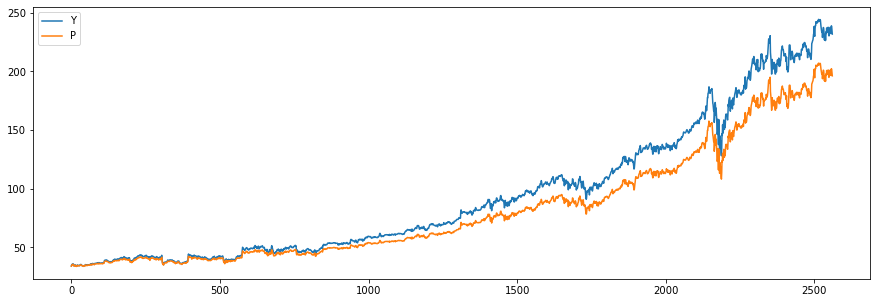

In [350]:
predictions=model.predict(vtx)
print("outputShape",predictions.shape)
vEvals=model.evaluate(vtx,vty,verbose=0)
%store vEvals >>a.txt
# print("Val Loss:",vEvals[0],"\tVal MAE:",vEvals[1])
plotCompare(vtx[:,-1],predictions[:,-1],["Y","P"])



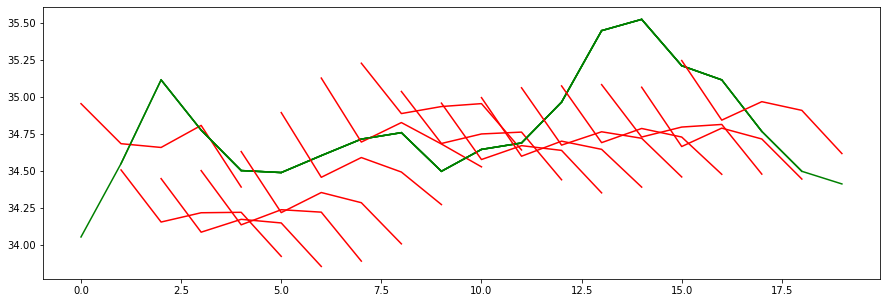

KeyboardInterrupt: 

In [97]:
plotVisual(vy,predictions,5)

In [19]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.supports_masking = True
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
class ScalerMult(Layer):
    def __init__(self, d_model):
        super(ScalerMult, self).__init__()
        self.mult = tf.math.sqrt(tf.cast(d_model, tf.float32))
        self.supports_masking = True
    def call(self, inputs):
        return inputs * self.mult   
def Encoder(dim,encoders,hidden,P,key_dim,l2,axis=-1,epsilon=1e-6):
    temp=[None]*encoders
    for e in range(encoders):
        AT= MultiHeadAttentionMaskProp(dim, key_dim)(P)
        AD1 = Add()([AT, P])
        NORM1 = LayerNormalization(epsilon=epsilon, axis=axis)(AD1)
        FF = Dense(hidden, 'relu', kernel_regularizer=tf.keras.regularizers.L2(l2=l2))(NORM1)
        FF = Dropout(0.4)(FF)
        FF = Dense(dim, 'relu')(FF)
        AD2 = Add()([FF, NORM1])
        temp[e]=LayerNormalization(epsilon=epsilon, axis=axis)(AD2)
    if encoders==1: return temp[0]
    return concatenate(temp) 

class MultiHeadAttentionMaskProp(layers.Layer):
    def __init__(self ,dim, key_dim, **kwargs):
        super(MultiHeadAttentionMaskProp,self).__init__(**kwargs)
        self.MultiHeadAttention = MultiHeadAttention(num_heads=dim, key_dim=key_dim)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        t=mask[:, tf.newaxis, tf.newaxis, :]
        output = self.MultiHeadAttention(inputs,inputs,inputs,t)  
        return output

In [20]:
def Encoder(dim,encoders,hidden,P,key_dim,l2,axis=-1,epsilon=1e-6):
    temp=[None]*encoders
    for e in range(encoders):
        AT= MultiHeadAttentionMaskProp(dim, key_dim)(P)
        AD1 = Add()([AT, P])
        NORM1 = LayerNormalization(epsilon=epsilon, axis=axis)(AD1)
        FF = Dense(hidden, 'relu', kernel_regularizer=tf.keras.regularizers.L2(l2=l2))(NORM1)
        FF = Dropout(0.4)(FF)
        FF = Dense(dim, 'relu')(FF)
        AD2 = Add()([FF, NORM1])
        temp[e]=LayerNormalization(epsilon=epsilon, axis=axis)(AD2)
    if encoders==1: return temp[0]
    return concatenate(temp) 

class MultiHeadAttentionMaskProp(layers.Layer):
    def __init__(self ,dim, key_dim, **kwargs):
        super(MultiHeadAttentionMaskProp,self).__init__(**kwargs)
        self.MultiHeadAttention = MultiHeadAttention(num_heads=dim, key_dim=key_dim)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        t=mask[:, tf.newaxis, tf.newaxis, :]
        output = self.MultiHeadAttention(inputs,inputs,inputs,t)  
        return output

In [6]:
tf.keras.backend.clear_session()
def LSTM_model(inputShape, hidden=16,encoders=5,key_dim=100,l2=0.5):
    x = Input(shape=inputShape)
    Ms= Masking()(x)
    E = ScalerMult(inputShape)(Ms)
    P = PositionalEncoding(inputShape[0], inputShape[1])(E)
    c=Encoder(inputShape[1],encoders,hidden,P,key_dim,l2,-1,epsilon=1e3)
    out = Dense(hidden, 'relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(c)
    out = Dense(1, 'linear')(out)
    M = tf.keras.models.Model(inputs=x, outputs=out)
    M.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss="huber")
    return M
model=LSTM_model(inputShape=trainx.shape[1:],hidden=100,encoders=5)
# tf.keras.utils.plot_model(model)
# model.summary()
H=model.fit(trainx, trainy,epochs=100,batch_size=500,validation_split=0.1,callbacks=callbacks)

NameError: name 'trainx' is not defined